<a href="https://colab.research.google.com/github/VigaNik/LeafDiseaseClassification/blob/main/LeafDiseaseClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clean cache (data from earlier runs)

In [1]:
# === Clean all old model artifacts ===
# This will remove checkpoints, logs, and any saved weights
# so that training starts from scratch.

import shutil
import os

# Common folders where models/logs are usually stored
folders_to_remove = [
    "/content/checkpoints",   # custom checkpoints
    "/content/logs",          # training logs (tensorboard, etc.)
    "/content/models",        # saved models
    "/content/runs",          # often used by torch or tensorboard
]
for folder in folders_to_remove:
    shutil.rmtree(folder, ignore_errors=True)
    print(f"[OK] Removed (if existed): {folder}")

# If you save weights with specific extensions (like .pth, .pt, .h5) in /content
# you can also wipe them all:
for f in os.listdir("/content"):
    if f.endswith((".pth", ".pt", ".h5", ".ckpt")):
        try:
            os.remove(os.path.join("/content", f))
            print(f"[OK] Removed file: {f}")
        except Exception as e:
            print(f"Could not remove {f}: {e}")

print("All old model files cleared. Training will start from scratch.")


[OK] Removed (if existed): /content/checkpoints
[OK] Removed (if existed): /content/logs
[OK] Removed (if existed): /content/models
[OK] Removed (if existed): /content/runs
All old model files cleared. Training will start from scratch.


In [2]:
# === Full cleanup of Colab working dirs ===
import shutil

folders_to_remove = [
    "/content/kagglehub_cache_1758281629",
    "/content/kagglehub_cache_1758281860",
    "/content/leaf_disease_data",
    "/content/sample_data"
]

for folder in folders_to_remove:
    shutil.rmtree(folder, ignore_errors=True)
    print(f"[OK] Removed: {folder}")

print(" Workspace cleaned. Now you have a fresh Colab environment (except Google Drive).")


[OK] Removed: /content/kagglehub_cache_1758281629
[OK] Removed: /content/kagglehub_cache_1758281860
[OK] Removed: /content/leaf_disease_data
[OK] Removed: /content/sample_data
 Workspace cleaned. Now you have a fresh Colab environment (except Google Drive).


In [3]:
# === Purge local Colab cache and (optionally) a dataset folder on Google Drive ===
# Run this BEFORE any import of kagglehub.

import os, shutil

# 1) Remove local kagglehub cache inside the Colab VM
local_cache = os.path.expanduser("~/.cache/kagglehub")
shutil.rmtree(local_cache, ignore_errors=True)
print(f"[OK] Removed local cache: {local_cache}")

# 2) (Optional) If you stored a copy on Google Drive, remove that too
#    Change this path if your dataset sits elsewhere in Drive.
drive_dataset_dir = "/content/drive/MyDrive/leaf-disease-dataset-combination"
shutil.rmtree(drive_dataset_dir, ignore_errors=True)
print(f"[OK] Removed Drive dataset folder (if existed): {drive_dataset_dir}")


[OK] Removed local cache: /root/.cache/kagglehub
[OK] Removed Drive dataset folder (if existed): /content/drive/MyDrive/leaf-disease-dataset-combination


In [4]:
# === Force a fresh download with an isolated, empty cache dir ===
# IMPORTANT: set env vars BEFORE importing kagglehub.

import os, time
from pathlib import Path

# Put kagglehub cache into a fresh, run-specific folder (so nothing is reused)
run_cache = Path(f"/content/kagglehub_cache_{int(time.time())}")
os.environ["XDG_CACHE_HOME"] = str(run_cache)   # kagglehub honors ~/.cache via XDG_CACHE_HOME
print("[INFO] Using isolated cache dir:", run_cache)

import kagglehub   # import AFTER setting XDG_CACHE_HOME

DATASET_ID = "asheniranga/leaf-disease-dataset-combination"

# Force download to bypass any previous cache
data_path = kagglehub.dataset_download(DATASET_ID, force_download=True)

print("[OK] Fresh dataset downloaded to:", data_path)
print("[CHECK] Cache root exists:", run_cache.exists())
print("[CHECK] Cache dir content entries:", len(list(run_cache.rglob('*'))))


[INFO] Using isolated cache dir: /content/kagglehub_cache_1759094814
Using Colab cache for faster access to the 'leaf-disease-dataset-combination' dataset.
[OK] Fresh dataset downloaded to: /kaggle/input/leaf-disease-dataset-combination
[CHECK] Cache root exists: False
[CHECK] Cache dir content entries: 0


# Import data, and GPU setup

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from collections import defaultdict

# Check GPU availability
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    print(" GPU detected and ready!")
else:
    print(" Using CPU")

# Simple setup
plt.style.use('default')
sns.set_palette("Set2")

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
 GPU detected and ready!




> Libraries and data import



In [6]:
from sklearn.datasets import fetch_openml
from sklearn import __version__ as skver
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn import metrics
import random, glob, os
from pathlib import Path
from IPython import get_ipython
from IPython.display import display
import kagglehub

In [7]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Setting up for beautiful graphs
plt.style.use('default')
sns.set_palette("husl")


In [8]:

from google.colab import drive
drive.mount('/content/drive')


from google.colab import drive
drive.mount('/content/drive')
zip_path = "/content/drive/MyDrive/ColabNotebooks/LeavesPhotoDF/leaf_disease.zip"

import zipfile
import os

extract_path = "/content/leaf_disease_data"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

data_path = Path(extract_path)

print("Data path set to:", data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data path set to: /content/leaf_disease_data


#ANALYSIS OF DATASET STRUCTURE

In [9]:
from pathlib import Path

root = Path(data_path)
if (root / "image data").exists():
    root = root / "image data"

EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def walk(p: Path, pref=""):
    files = [f for f in p.iterdir() if f.is_file() and f.suffix.lower() in EXTS]
    dirs  = [d for d in p.iterdir() if d.is_dir()]
    if files:
        print(f"{pref}{p.name}  [images: {len(files)}]")
        return
    print(f"{pref}{p.name}/")
    for d in sorted(dirs, key=lambda x: x.name.lower()):
        walk(d, pref + "  - ")
walk(root)

image data/
  - test/
  -   - apple/
  -   -   - apple scab  [images: 63]
  -   -   - black rot  [images: 62]
  -   -   - cedar apple rust  [images: 27]
  -   -   - healthy  [images: 164]
  -   - Cassava/
  -   -   - Bacterial Blight (CBB)  [images: 109]
  -   -   - Brown Streak Disease (CBSD)  [images: 125]
  -   -   - Green Mottle (CGM)  [images: 125]
  -   -   - Healthy  [images: 203]
  -   -   - Mosaic Disease (CMD)  [images: 125]
  -   - cherry (including sour)/
  -   -   - healthy  [images: 85]
  -   -   - powdery mildew  [images: 105]
  -   - corn (maize)/
  -   -   - cercospora leaf spot gray leaf spot  [images: 51]
  -   -   - common rust  [images: 119]
  -   -   - healthy  [images: 116]
  -   -   - northern leaf blight  [images: 98]
  -   - grape/
  -   -   - black rot  [images: 118]
  -   -   - esca (black measles)  [images: 138]
  -   -   - healthy  [images: 42]
  -   -   - leaf blight (isariopsis leaf spot)  [images: 107]
  -   - orange/
  -   -   - haunglongbing (citrus g

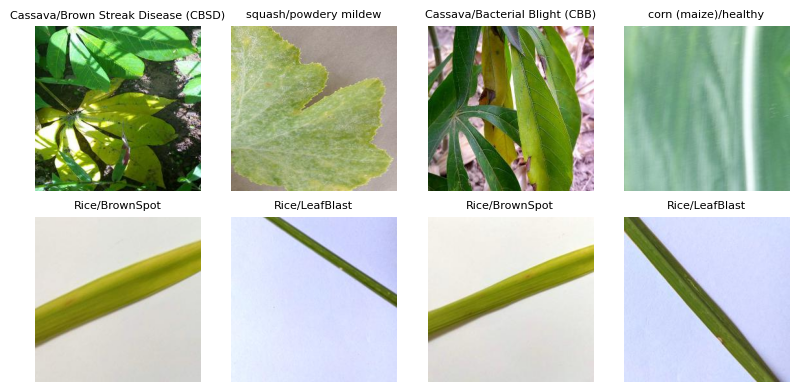

In [10]:
import random, glob, os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

root = Path(data_path) / "image data" if (Path(data_path) / "image data").exists() else Path(data_path)
exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
imgs = sum((list(root.rglob(e)) for e in exts), [])
sampled = random.sample(imgs, 8)

fig, ax = plt.subplots(2, 4, figsize=(8,4))
for i in range(2):
    for j in range(4):
        p = sampled[i*4 + j]
        img = Image.open(p)
        ax[i, j].imshow(img)
        rel = p.relative_to(root)
        ax[i, j].set_title("/".join(rel.parts[-3:-1]), fontsize=8)  # last two folders
        ax[i, j].axis('off')
plt.tight_layout()

In [11]:
data = []
root = Path(data_path) / "image data" if (Path(data_path) / "image data").exists() else Path(data_path)

for split in ['train', 'test', 'validation']:
    split_path = root / split
    if split_path.exists():
        for plant in os.listdir(split_path):
            plant_path = split_path / plant
            if plant_path.is_dir():
                for disease in os.listdir(plant_path):
                    disease_path = plant_path / disease
                    if disease_path.is_dir():
                        image_count = len([f for f in os.listdir(disease_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp'))])
                        is_healthy = 'healthy' in disease.lower() # Assuming 'healthy' is in the folder name for healthy plants
                        data.append([split, plant, disease, image_count, is_healthy])

df = pd.DataFrame(data, columns=['split', 'plant', 'disease', 'count', 'is_healthy'])
display(df.head())

,split,plant,disease,count,is_healthy
0,train,strawberry,healthy,329,True
1,train,strawberry,leaf scorch,800,False
2,train,apple,healthy,1185,True
3,train,apple,cedar apple rust,199,False
4,train,apple,apple scab,454,False


##Visualization  by Hierarchical Clusteringera and Decision Tree



> 'Plant Similarity Matrix and Disease Co-occurrence Matrix





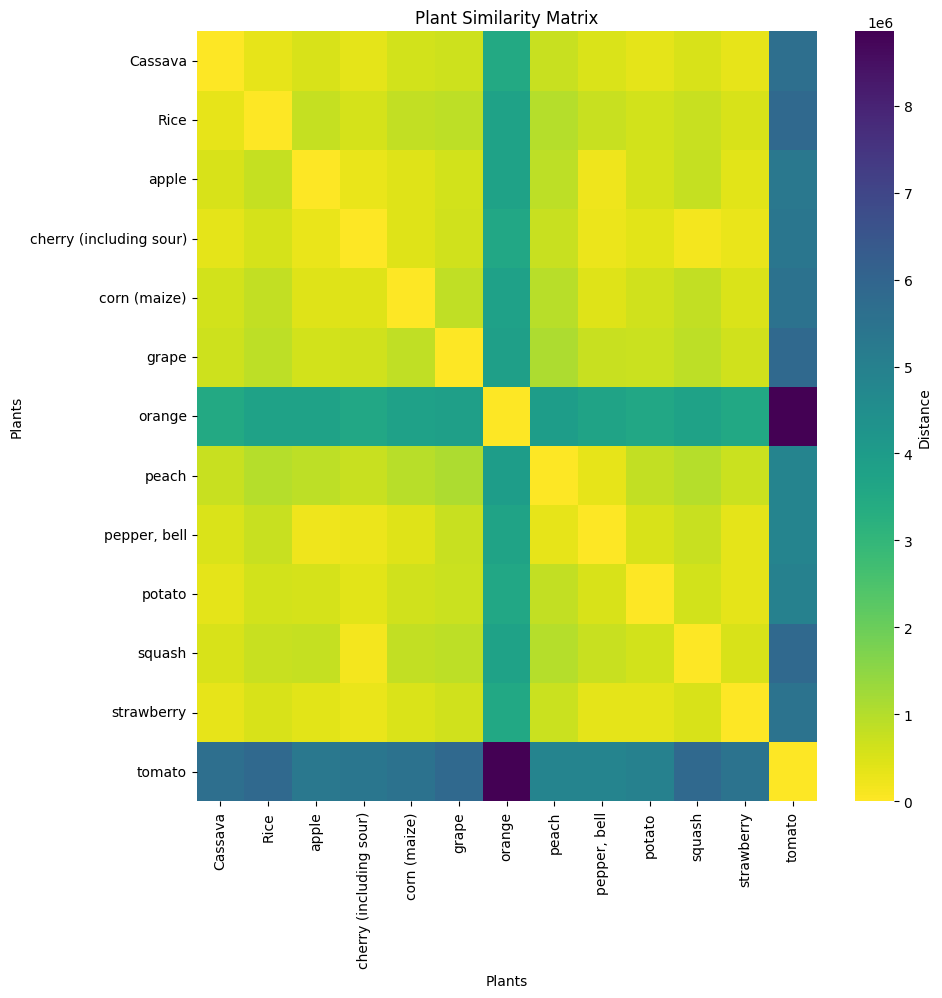

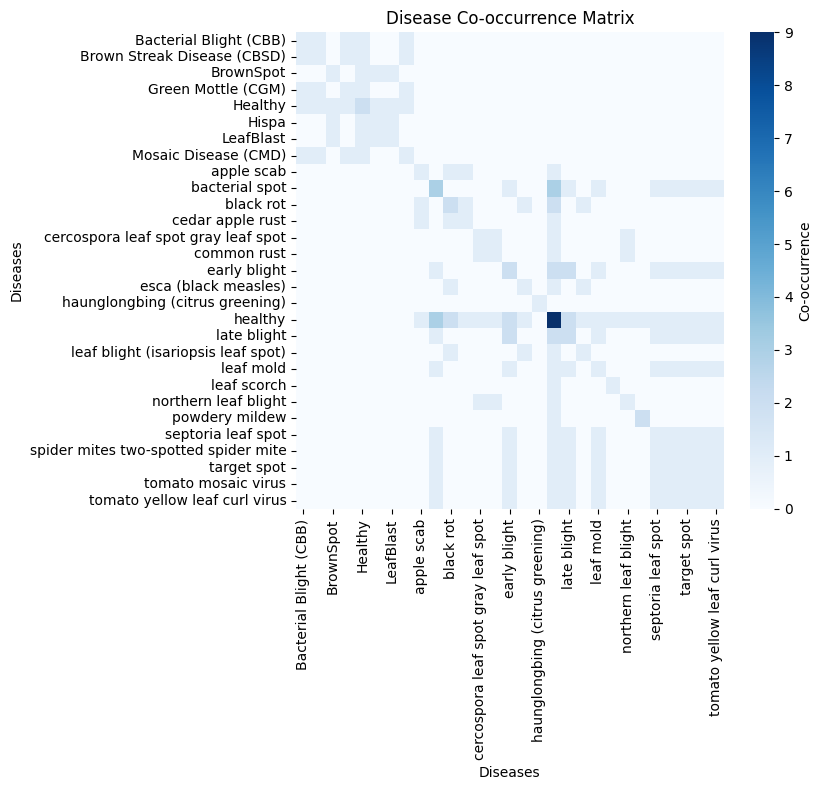

In [12]:
def simple_clustering_viz(df):
    """Simple clustering using GPU when possible"""

    # Create simple feature matrix
    pivot_table = df.pivot_table(values='count',
                                index='plant',
                                columns='disease',
                                fill_value=0)

    # Use GPU for computation if available
    if tf.config.list_physical_devices('GPU'):
        with tf.device('/GPU:0'):
            # Convert to tensor for GPU computation
            data_tensor = tf.constant(pivot_table.values, dtype=tf.float32)

            # Simple distance calculation on GPU
            distances = tf.reduce_sum(tf.square(data_tensor[:, None] - data_tensor[None, :]), axis=2)
            distances_np = distances.numpy()
    else:
        # CPU fallback
        from scipy.spatial.distance import pdist, squareform
        distances_np = squareform(pdist(pivot_table.values))

    # Simple hierarchical clustering visualization
    plt.figure(figsize=(22, 10))

    # Create a simple similarity heatmap
    plt.subplot(1, 2, 1)
    sns.heatmap(distances_np,
                xticklabels=pivot_table.index,
                yticklabels=pivot_table.index,
                cmap='viridis_r',
                cbar_kws={'label': 'Distance'})
    plt.title('Plant Similarity Matrix')
    plt.xlabel('Plants')
    plt.ylabel('Plants')



     # Simple hierarchical clustering visualization
    plt.figure(figsize=(14, 8))
    # Disease co-occurrence matrix
    plt.subplot(1, 2, 2)
    disease_cooccur = (pivot_table > 0).astype(int)
    sns.heatmap(disease_cooccur.T @ disease_cooccur,
                cmap='Blues',
                cbar_kws={'label': 'Co-occurrence'})
    plt.title('Disease Co-occurrence Matrix')
    plt.xlabel('Diseases')
    plt.ylabel('Diseases')


    plt.tight_layout()
    plt.show()

simple_clustering_viz(df)



> Plant-Disease Distribution





🔍 PLANT-DISEASE RELATIONSHIP MATRIX


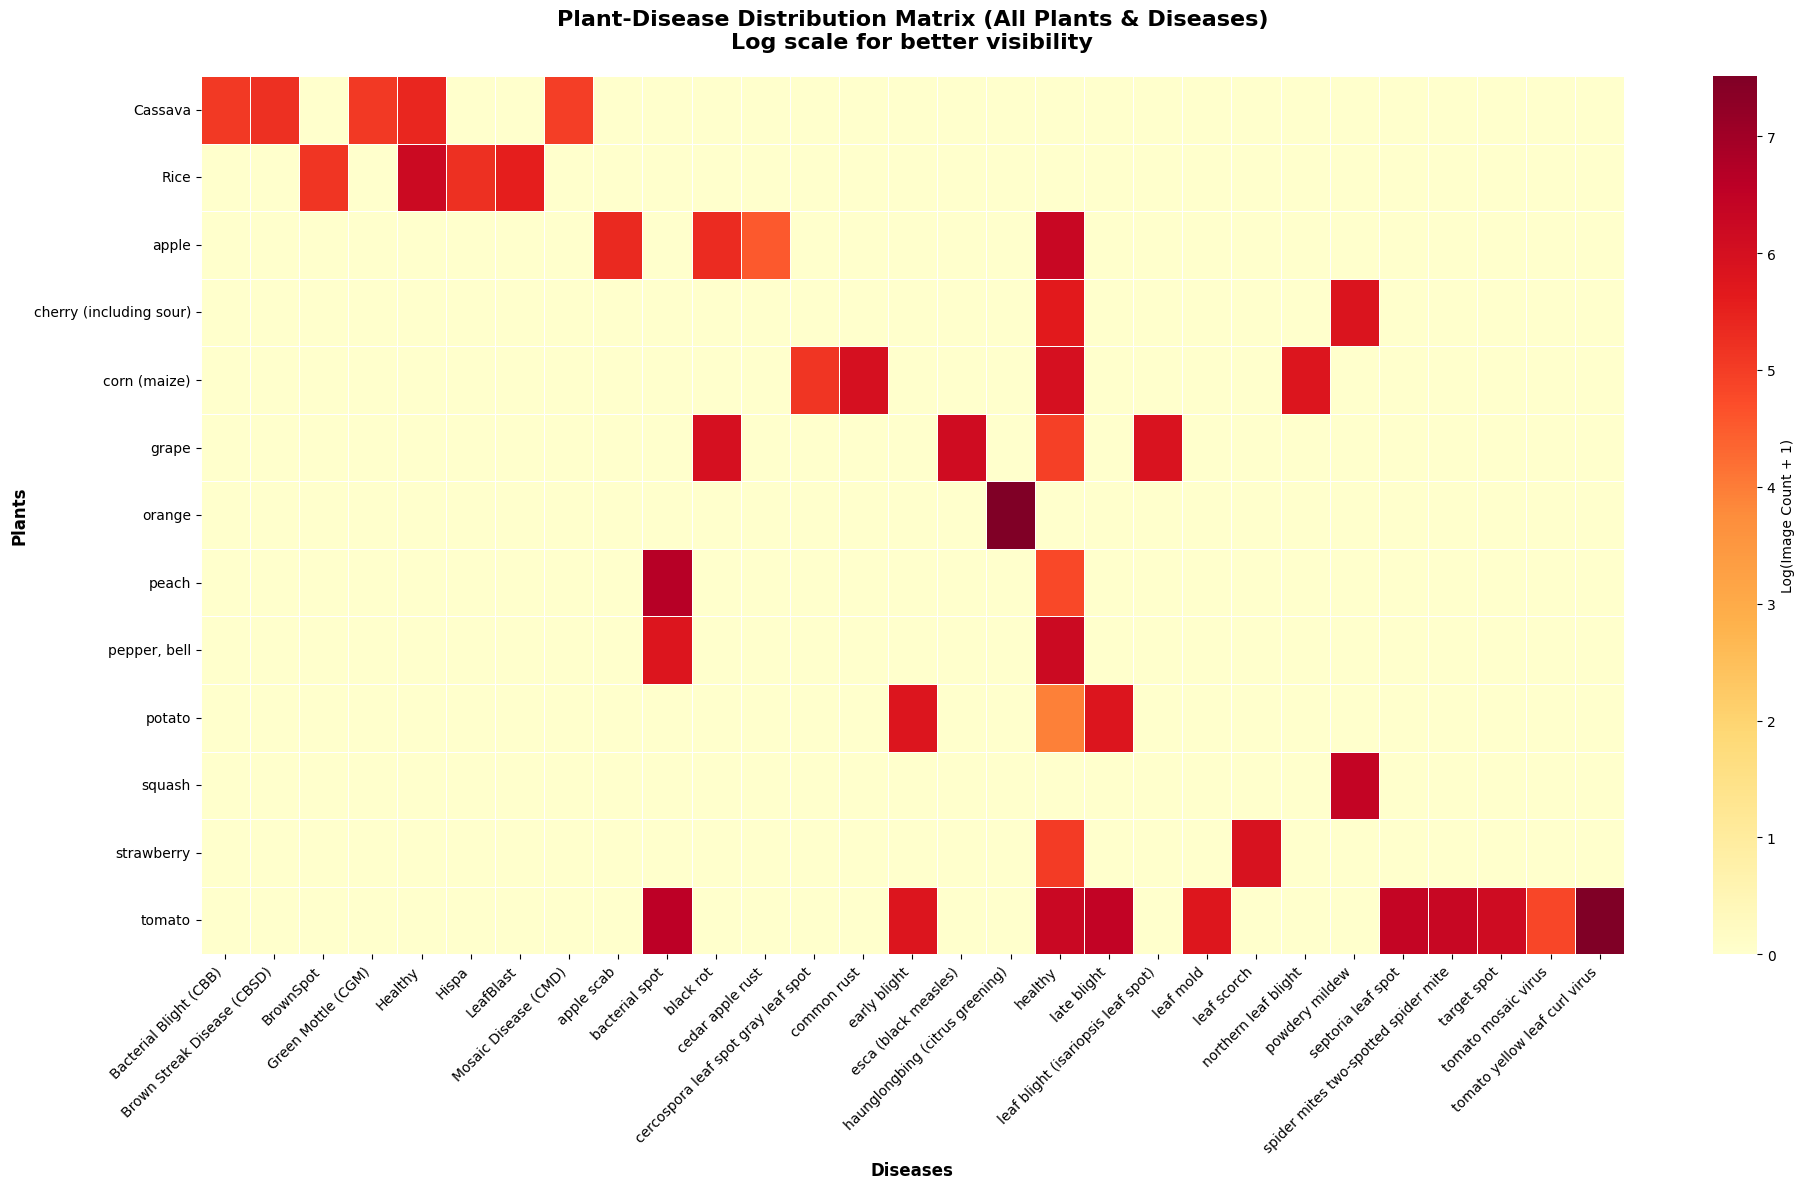


 TOP DISEASE PER PLANT:
   Cassava                  : Healthy                        (225.0 images)
   Rice                     : Healthy                        (496.0 images)
   apple                    : healthy                        (548.3333333333334 images)
   cherry (including sour)  : powdery mildew                 (350.6666666666667 images)
   corn (maize)             : common rust                    (397.3333333333333 images)
   grape                    : esca (black measles)           (461.0 images)
   orange                   : haunglongbing (citrus greening) (1,835.6666666666667 images)
   peach                    : bacterial spot                 (765.6666666666666 images)
   pepper, bell             : healthy                        (492.6666666666667 images)
   potato                   : early blight                   (333.3333333333333 images)
   squash                   : powdery mildew                 (611.6666666666666 images)
   strawberry               : leaf scorc

In [13]:
def plot_plant_disease_matrix(df):
    """Create a comprehensive plant-disease matrix showing all relationships"""

    print(f"\n🔍 PLANT-DISEASE RELATIONSHIP MATRIX")
    print("="*50)

    # Create pivot table
    pivot_table = df.pivot_table(values='count',
                                index='plant',
                                columns='disease',
                                fill_value=0)

    # Create the heatmap
    plt.figure(figsize=(20, 12))

    # Use log scale for better visualization
    pivot_log = np.log1p(pivot_table)  # log(1+x) to handle zeros

    # Create heatmap
    sns.heatmap(pivot_log,
                cmap='YlOrRd',
                cbar_kws={'label': 'Log(Image Count + 1)'},
                linewidths=0.5,
                square=False)

    plt.title('Plant-Disease Distribution Matrix (All Plants & Diseases)\nLog scale for better visibility',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Diseases', fontsize=12, fontweight='bold')
    plt.ylabel('Plants', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)

    plt.tight_layout()
    plt.show()

    # Show top combinations per plant
    print(f"\n TOP DISEASE PER PLANT:")
    for plant in pivot_table.index:
        plant_row = pivot_table.loc[plant]
        top_disease = plant_row.idxmax()
        top_count = plant_row.max()
        print(f"   {plant:<25}: {top_disease:<30} ({top_count:,} images)")


print("\n" + "="*60)
plot_plant_disease_matrix(df)

> Analysis: Top Plant-Disease Combinations

Creating complete hierarchy visualization...


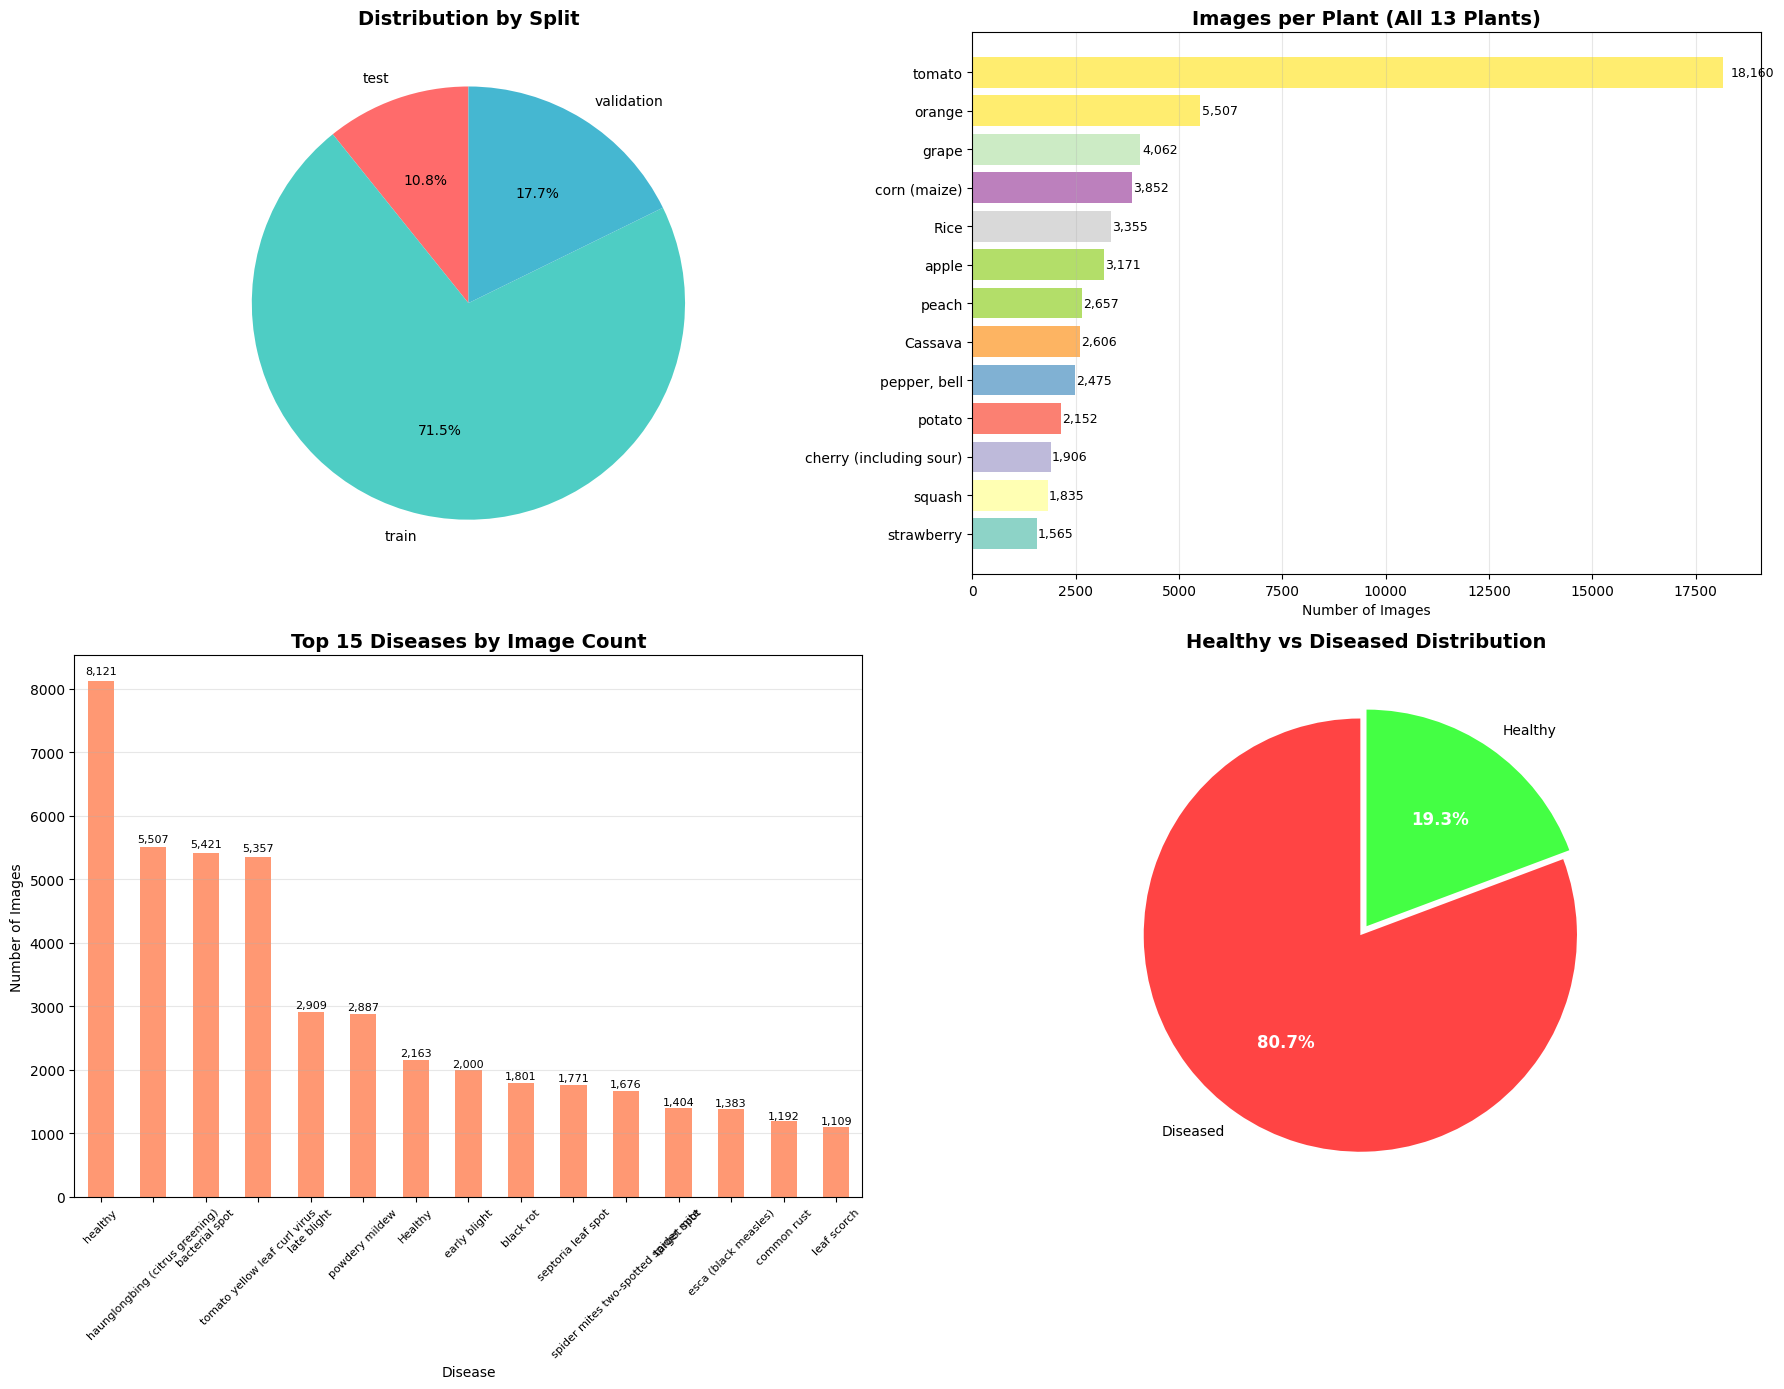


 COMPLETE PLANT BREAKDOWN (All 13 Plants)
 1. tomato                    : 18,160 images ( 34.1%) | 10 diseases |  8.8% healthy
 2. orange                    :  5,507 images ( 10.3%) |  1 diseases |  0.0% healthy
 3. grape                     :  4,062 images (  7.6%) |  4 diseases | 10.4% healthy
 4. corn (maize)              :  3,852 images (  7.2%) |  4 diseases | 30.2% healthy
 5. Rice                      :  3,355 images (  6.3%) |  4 diseases | 44.4% healthy
 6. apple                     :  3,171 images (  5.9%) |  4 diseases | 51.9% healthy
 7. peach                     :  2,657 images (  5.0%) |  2 diseases | 13.5% healthy
 8. Cassava                   :  2,606 images (  4.9%) |  5 diseases | 25.9% healthy
 9. pepper, bell              :  2,475 images (  4.6%) |  2 diseases | 59.7% healthy
10. potato                    :  2,152 images (  4.0%) |  3 diseases |  7.1% healthy
11. cherry (including sour)   :  1,906 images (  3.6%) |  2 diseases | 44.8% healthy
12. squash            

In [14]:
def plot_complete_hierarchy(df):
    """Create comprehensive hierarchical plots showing all plants and diseases"""

    # Create larger figure to accommodate all data
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # 1. Split distribution
    split_counts = df.groupby('split')['count'].sum()
    colors_splits = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    axes[0,0].pie(split_counts.values, labels=split_counts.index, autopct='%1.1f%%',
                  colors=colors_splits, startangle=90)
    axes[0,0].set_title('Distribution by Split', fontsize=14, fontweight='bold')

    # 2. ALL Plants distribution (horizontal bar chart for better readability)
    plant_counts = df.groupby('plant')['count'].sum().sort_values(ascending=True)

    # Create color map for plants
    colors_plants = plt.cm.Set3(np.linspace(0, 1, len(plant_counts)))

    bars = axes[0,1].barh(range(len(plant_counts)), plant_counts.values, color=colors_plants)
    axes[0,1].set_yticks(range(len(plant_counts)))
    axes[0,1].set_yticklabels(plant_counts.index, fontsize=10)
    axes[0,1].set_title('Images per Plant (All 13 Plants)', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Number of Images')
    axes[0,1].grid(axis='x', alpha=0.3)

    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[0,1].text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                      f'{int(width):,}', ha='left', va='center', fontsize=9)

    # 3. Top diseases distribution (show more diseases)
    disease_counts = df.groupby('disease')['count'].sum().sort_values(ascending=False).head(15)

    # Rotate the bar chart and make it more readable
    disease_counts.plot(kind='bar', ax=axes[1,0], color='coral', alpha=0.8)
    axes[1,0].set_title('Top 15 Diseases by Image Count', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Disease')
    axes[1,0].set_ylabel('Number of Images')
    axes[1,0].tick_params(axis='x', rotation=45, labelsize=8)
    axes[1,0].grid(axis='y', alpha=0.3)

    # Add value labels on top of bars
    for i, (disease, count) in enumerate(disease_counts.items()):
        axes[1,0].text(i, count + count*0.01, f'{int(count):,}',
                      ha='center', va='bottom', fontsize=8, rotation=0)

    # 4. Healthy vs Diseased
    health_counts = df.groupby('is_healthy')['count'].sum()
    colors_health = ['#FF4444', '#44FF44']  # Red for diseased, green for healthy
    labels_health = ['Diseased', 'Healthy']

    wedges, texts, autotexts = axes[1,1].pie(health_counts.values,
                                           labels=labels_health,
                                           autopct='%1.1f%%',
                                           colors=colors_health,
                                           startangle=90,
                                           explode=(0.05, 0))  # Slightly separate slices

    axes[1,1].set_title('Healthy vs Diseased Distribution', fontsize=14, fontweight='bold')

    # Make percentage text more readable
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)

    plt.tight_layout()
    plt.show()

    # Additional detailed breakdown
    print("\n" + "="*80)
    print(" COMPLETE PLANT BREAKDOWN (All 13 Plants)")
    print("="*80)

    total_images = df['count'].sum()

    for i, (plant, count) in enumerate(plant_counts.sort_values(ascending=False).items(), 1):
        percentage = (count / total_images) * 100

        # Get disease count for this plant
        plant_diseases = df[df['plant'] == plant]['disease'].nunique()

        # Get healthy percentage for this plant
        plant_data = df[df['plant'] == plant]
        healthy_count = plant_data[plant_data['is_healthy'] == True]['count'].sum()
        healthy_pct = (healthy_count / count) * 100 if count > 0 else 0

        print(f"{i:2d}. {plant:<25} : {count:>6,} images ({percentage:5.1f}%) | "
              f"{plant_diseases:2d} diseases | {healthy_pct:4.1f}% healthy")

    print(f"\n SUMMARY STATISTICS:")
    print(f"   Total Plants: {plant_counts.nunique()}")
    print(f"   Total Images: {total_images:,}")
    print(f"   Average per Plant: {total_images/len(plant_counts):,.0f} images")
    print(f"   Largest Plant: {plant_counts.max():,} images ({plant_counts.idxmax()})")
    print(f"   Smallest Plant: {plant_counts.min():,} images ({plant_counts.idxmin()})")
    print(f"   Imbalance Ratio: {plant_counts.max()/plant_counts.min():.1f}x")

# Execute both functions
print("Creating complete hierarchy visualization...")
plot_complete_hierarchy(df)


#Data cleaning and preperation



Heare we cleaning "orange" and "squash" leaves. Because we don't have healthy seples into. That resone why we disaide to frop this failes. also data is very anbalanse. We have to much tomato and for exthample.

In [15]:
from pathlib import Path
import shutil
import re
import os

# dataset root (after unzip)
root = Path(data_path)

DROP_RAW = {"orange", "squash"}

def norm_name(s: str) -> str:
    s = s.lower().strip()
    s = s.replace("___", " ").replace("__", " ").replace("_", " ")
    s = re.sub(r"\s+", " ", s)
    return s

DROP = {norm_name(x) for x in DROP_RAW}

removed = 0
for root, dirs, files in os.walk(root):
    for dname in list(dirs):
        if norm_name(dname) in DROP:
            p = Path(root) / dname
            shutil.rmtree(p, ignore_errors=True)
            removed += 1
            print(f"Removed: {p}")

print("Total removed dirs:", removed)


Removed: /content/leaf_disease_data/image data/train/squash
Removed: /content/leaf_disease_data/image data/train/orange
Removed: /content/leaf_disease_data/image data/test/squash
Removed: /content/leaf_disease_data/image data/test/orange
Removed: /content/leaf_disease_data/image data/validation/squash
Removed: /content/leaf_disease_data/image data/validation/orange
Total removed dirs: 6


In [16]:
!pip -q install imagehash

Likely issues to check

Corrupt/unreadable files, wrong extensions

Class imbalance and long-tail classes

Inconsistent labels (case/spaces/punctuation)

Leakage/duplicates across train/val/test

Wildly varying sizes/aspect ratios; non-RGB/alpha channels; EXIF rotation

Very small/blank images

In [17]:
from pathlib import Path
from PIL import Image, ImageOps
import imagehash, numpy as np
from collections import Counter, defaultdict
import re, random
import matplotlib.pyplot as plt

root = Path(data_path)
root = root / "image data" if (root / "image data").exists() else root
EXTS = {".jpg",".jpeg",".png",".bmp",".webp"}
SPLITS = [p.name for p in root.iterdir() if p.is_dir()]  # auto-detect splits
SPLITS = sorted([s for s in SPLITS if (root/s).is_dir()])

def norm_label(s):
    return re.sub(r"[^a-z0-9]+","_", s.lower()).strip("_")

tot, bad = 0, []
dims_w, dims_h = [], []
modes = Counter()
per_split = Counter()
per_class = Counter()
per_split_class = Counter()
label_map = defaultdict(set)   # normalized -> original variants
hash_to_paths = defaultdict(list)

# Limit hashing if huge (for speed). Set to None to hash all.
MAX_HASH = 6000
hash_sample = []

for split in SPLITS:
    split_dir = root / split
    for cls in sorted([d.name for d in split_dir.iterdir() if d.is_dir()]):
        cls_dir = split_dir / cls
        label_map[norm_label(cls)].add(cls)
        for p in cls_dir.rglob("*"):
            if p.suffix.lower() not in EXTS: continue
            try:
                with Image.open(p) as im:
                    im = ImageOps.exif_transpose(im)
                    modes[im.mode] += 1
                    w,h = im.size
                    dims_w.append(w); dims_h.append(h)
            except Exception as e:
                bad.append((str(p), str(e))); continue
            tot += 1
            per_split[split] += 1
            per_class[cls] += 1
            per_split_class[(split, cls)] += 1
            # sample for duplicate/leakage check
            if MAX_HASH is None or len(hash_sample) < MAX_HASH or random.random() < MAX_HASH/max(1,tot):
                hash_sample.append(p)

# compute perceptual hashes on sample
for p in hash_sample:
    try:
        with Image.open(p) as im:
            ah = imagehash.phash(im, hash_size=12)  # robust & reasonably fast
        hash_to_paths[str(ah)].append(str(p))
    except Exception:
        pass

# summarize
def q(x, qs=(.01,.5,.99)):
    return tuple(int(np.quantile(x, q)) for q in qs)

print("=== Basic counts ===")
print("Total images:", tot)
for s in SPLITS: print(f"  {s}: {per_split[s]}")

print("\n=== Classes (Top 5 most/least) ===")
most = per_class.most_common(5)
least = sorted(per_class.items(), key=lambda kv: kv[1])[:5]
print("Most:", most)
print("Least:", least)

print("\n=== Image sizes (W,H) quantiles [1%, 50%, 99%] ===")
print("W:", q(dims_w), "H:", q(dims_h))

print("\n=== Modes (color channels) ===")
print(dict(modes))  # expect mostly 'RGB'; flags if 'L','RGBA', etc.

# label inconsistencies
collisions = {k:v for k,v in label_map.items() if len(v) > 1}
print("\n=== Label normalization collisions (potential inconsistencies) ===")
print(collisions if collisions else "None")

# corrupts
print("\n=== Corrupt/unreadable files ===")
print(f"Count: {len(bad)}")
for p, e in bad[:5]: print("  ", p, "|", e)
if len(bad) > 5: print("  ...")

# duplicates/leakage (sampled)
dupe_groups = {h:ps for h,ps in hash_to_paths.items() if len(ps) > 1}
print("\n=== Near-duplicates / cross-split leakage (sampled) ===")
print(f"Groups with >1 match (sample size {len(hash_sample)}):", len(dupe_groups))
shown = 0
for h, paths in list(dupe_groups.items())[:3]:
    splits = {Path(p).parts[-len(Path(root).parts)-3] for p in paths if "image data" in p}
    print(f"  hash {h} | splits seen: {splits}")
    for p in paths[:4]: print("    ", p)
    shown += 1
if len(dupe_groups) > shown: print("  ...")

=== Basic counts ===
Total images: 45961
  test: 5008
  train: 32816
  validation: 8137

=== Classes (Top 5 most/least) ===
Most: [('tomato', 18160), ('grape', 4062), ('corn (maize)', 3852), ('Rice', 3355), ('apple', 3171)]
Least: [('strawberry', 1565), ('cherry (including sour)', 1906), ('potato', 2152), ('pepper, bell', 2475), ('Cassava', 2606)]

=== Image sizes (W,H) quantiles [1%, 50%, 99%] ===
W: (256, 256, 256) H: (256, 256, 256)

=== Modes (color channels) ===
{'RGB': 45961}

=== Label normalization collisions (potential inconsistencies) ===
None

=== Corrupt/unreadable files ===
Count: 0

=== Near-duplicates / cross-split leakage (sampled) ===
Groups with >1 match (sample size 18269): 2062
  hash c71aae4e271bacf3cd5b09a3348088f2c47f | splits seen: {'content'}
     /content/leaf_disease_data/image data/test/Cassava/Mosaic Disease (CMD)/112619806.jpg
     /content/leaf_disease_data/image data/train/Cassava/Mosaic Disease (CMD)/112619806.jpg
  hash 9c5b950ed19cf8464799a7f00684aeef

##Duplicates detection

 SIMPLE DUPLICATE DETECTION
 Finding duplicates in all images...
 Processing 45,961 images


Computing hashes: 100%|██████████| 45961/45961 [02:00<00:00, 382.17it/s]



 Results:
 Found 7810 duplicate groups
 Total duplicates: 12135

 Duplicate Analysis:

 Group 1 (CROSS-SPLIT):
  train/strawberry/525ea4dd-84e2-4a43-9927-41cd69543db4___RS_HL 4457.JPG
  validation/strawberry/525ea4dd-84e2-4a43-9927-41cd69543db4___RS_HL 4457.JPG
  test/strawberry/525ea4dd-84e2-4a43-9927-41cd69543db4___RS_HL 4457.JPG

 Group 2 (CROSS-SPLIT):
  train/strawberry/30c218c0-6fb6-45d8-a645-43be89932d06___RS_HL 2005.JPG
  validation/strawberry/30c218c0-6fb6-45d8-a645-43be89932d06___RS_HL 2005.JPG

 Group 3 (CROSS-SPLIT):
  train/strawberry/0d9c97af-4a3e-41f5-9c42-534898ea1688___RS_HL 4375.JPG
  validation/strawberry/0d9c97af-4a3e-41f5-9c42-534898ea1688___RS_HL 4375.JPG
  test/strawberry/0d9c97af-4a3e-41f5-9c42-534898ea1688___RS_HL 4375.JPG

 Group 4 (CROSS-SPLIT):
  train/strawberry/d454c3f8-ca2e-4935-9c09-3b6a480ac097___RS_HL 1870.JPG
  validation/strawberry/d454c3f8-ca2e-4935-9c09-3b6a480ac097___RS_HL 1870.JPG
  test/strawberry/d454c3f8-ca2e-4935-9c09-3b6a480ac097___RS_HL 18

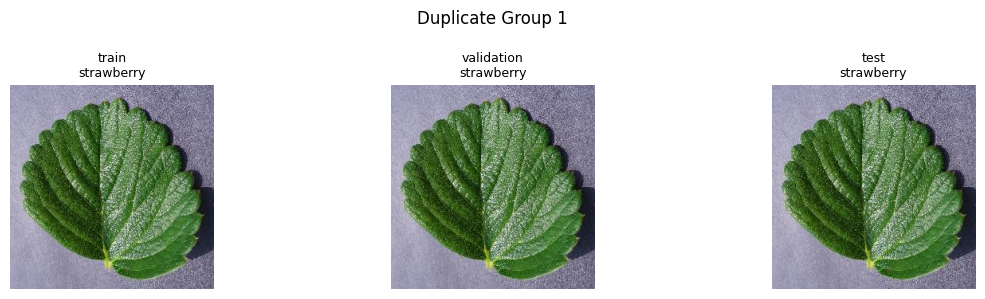

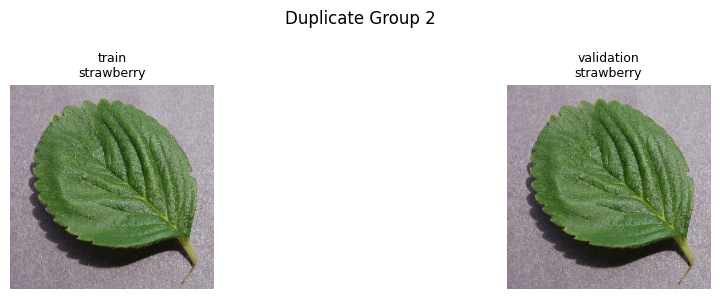

Показано результат, скорочений до останніх рядків (5000).
 Remove: test/tomato/f8b06c4f-6f3a-44dd-9a70-2ab2a9be23e6___Com.G_SpM_FL 1534.JPG
 Keep: train/tomato/af0d2ecc-72f9-40ca-ad16-b3ef9419e9ec___Com.G_SpM_FL 9559.JPG
 Remove: validation/tomato/af0d2ecc-72f9-40ca-ad16-b3ef9419e9ec___Com.G_SpM_FL 9559.JPG
 Keep: train/tomato/e346d87d-cd42-425f-a7a0-8fca01cb6f75___Com.G_SpM_FL 8550.JPG
 Remove: validation/tomato/e346d87d-cd42-425f-a7a0-8fca01cb6f75___Com.G_SpM_FL 8550.JPG
 Keep: train/tomato/0bb186a0-f27a-41b1-b0d2-5cf82eb87251___Com.G_SpM_FL 9018.JPG
 Remove: validation/tomato/0bb186a0-f27a-41b1-b0d2-5cf82eb87251___Com.G_SpM_FL 9018.JPG
 Keep: train/tomato/9c6749a6-781b-4700-bf38-d7e441a593d9___Com.G_SpM_FL 1394.JPG
 Remove: validation/tomato/9c6749a6-781b-4700-bf38-d7e441a593d9___Com.G_SpM_FL 1394.JPG
 Keep: train/tomato/5d0e79cc-2a50-49cf-9d1c-d5dc064545f3___Com.G_SpM_FL 9306.JPG
 Remove: validation/tomato/5d0e79cc-2a50-49cf-9d1c-d5dc064545f3___Com.G_SpM_FL 9306.JPG
 Remove: test/t

In [18]:
from pathlib import Path
from PIL import Image, ImageOps
import imagehash
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

root = Path(data_path) / "image data"
exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def get_all_images():
    """Get all images with metadata"""
    images = []
    for split in ["train", "validation", "test"]:
        split_dir = root / split
        if split_dir.exists():
            for img_path in split_dir.rglob("*"):
                if img_path.suffix.lower() in exts:
                    parts = img_path.relative_to(split_dir).parts
                    images.append({
                        'path': img_path,
                        'split': split,
                        'plant': parts[0] if parts else 'unknown',
                        'name': img_path.name
                    })
    return images

def compute_hash(img_path):
    """Compute multiple hashes for better accuracy"""
    try:
        with Image.open(img_path) as img:
            img = ImageOps.exif_transpose(img).convert("RGB")  # Ensure 3 channels
            # Use 3 different hash methods
            phash = str(imagehash.phash(img, hash_size=12))
            ahash = str(imagehash.average_hash(img, hash_size=12))
            dhash = str(imagehash.dhash(img, hash_size=12))
            return f"{phash}_{ahash}_{dhash}"
    except Exception as e:
        # print(f"Error processing {img_path}: {e}") # Optional: uncomment for debugging
        return None

def find_duplicates():
    """Find all duplicates using hash comparison"""
    print(" Finding duplicates in all images...")
    # Get all images
    all_images = get_all_images()
    print(f" Processing {len(all_images):,} images")

    # Compute hashes
    hash_to_images = defaultdict(list)
    for img_info in tqdm(all_images, desc="Computing hashes"):
        img_hash = compute_hash(img_info['path'])
        if img_hash:
            hash_to_images[img_hash].append(img_info)

    # Find duplicate groups
    duplicates = [group for group in hash_to_images.values() if len(group) > 1]
    print(f"\n Results:")
    print(f" Found {len(duplicates)} duplicate groups")
    print(f" Total duplicates: {sum(len(group)-1 for group in duplicates)}")
    return duplicates

def analyze_duplicates(duplicate_groups):
    """Analyze and show duplicate patterns"""
    cross_split = 0
    same_split = 0
    print(f"\n Duplicate Analysis:")
    for i, group in enumerate(duplicate_groups[:5]): # Show first 5 groups
        splits = set(img['split'] for img in group)
        if len(splits) > 1:
            cross_split += 1
            print(f"\n Group {i+1} (CROSS-SPLIT):")
        else:
            same_split += 1
            print(f"\n Group {i+1} (Same split: {list(splits)[0]}):")
        for img in group:
            print(f"  {img['split']}/{img['plant']}/{img['name']}")
    print(f"\n Summary:")
    print(f"  Cross-split duplicates: {cross_split}")
    print(f"  Same-split duplicates: {same_split}")
    return cross_split > 0

def show_examples(duplicate_groups, num_examples=2):
    """Show visual examples of duplicates"""
    print(f"\n Visual Examples:")
    for i, group in enumerate(duplicate_groups[:num_examples]):
        fig, axes = plt.subplots(1, min(len(group), 4), figsize=(12, 3))
        if len(group) == 1:
             axes = [axes] # Ensure axes is iterable even for single image group
        for j, img in enumerate(group[:4]):
            try:
                with Image.open(img['path']) as pil_img:
                    axes[j].imshow(pil_img)
                    axes[j].set_title(f"{img['split']}\n{img['plant']}", fontsize=9)
                    axes[j].axis('off')
            except:
                axes[j].text(0.5, 0.5, "Error", ha='center')
        plt.suptitle(f'Duplicate Group {i+1}')
        plt.tight_layout()
        plt.show()


def remove_duplicates(duplicate_groups):
    """Remove duplicates keeping train > validation > test priority"""
    priority = ['train', 'validation', 'test']
    removed = 0
    print(f"\n Removing duplicates (priority: {' > '.join(priority)}):")
    for group in duplicate_groups:
        # Sort by priority
        sorted_group = sorted(group, key=lambda x: priority.index(x['split']) if x['split'] in priority else 999)
        # Keep first, remove others
        keep = sorted_group[0]
        remove_list = sorted_group[1:]

        # Check if the image to keep actually exists before printing keep message
        if keep['path'].exists():
            print(f" Keep: {keep['split']}/{keep['plant']}/{keep['name']}")
        else:
             # If the image to keep doesn't exist, keep the next available one
             print(f" Warning: Image to keep {keep['path']} not found. Keeping the next available image in the group.")
             keep = None
             for img in sorted_group:
                 if img['path'].exists():
                     keep = img
                     print(f" Keep: {keep['split']}/{keep['plant']}/{keep['name']}")
                     break
             if keep is None:
                 print(" Error: No image to keep found in the group.")
                 continue # Skip to next group if no image to keep is found

             remove_list = [img for img in sorted_group if img != keep]


        for img in remove_list:
            try:
                if img['path'].exists(): # Check if file exists before attempting to remove
                    img['path'].unlink()
                    print(f" Remove: {img['split']}/{img['plant']}/{img['name']}")
                    removed += 1
                # else:
                    # print(f" Info: Image to remove {img['path']} not found (already removed?)") # Optional: uncomment for debugging
            except Exception as e:
                print(f"Error removing {img['path']}: {e}") # Print specific error

    print(f"\n Removed {removed} duplicate files")
    return removed

# Execute duplicate detection
print(" SIMPLE DUPLICATE DETECTION")
print("="*40)

# Find duplicates
duplicates = find_duplicates()

if duplicates:
    # Analyze patterns
    has_cross_split = analyze_duplicates(duplicates)

    # Show examples
    show_examples(duplicates)

    # Warning for cross-split duplicates
    if has_cross_split:
        print(f"\n WARNING: Cross-split duplicates found!")
        print(f" This causes data leakage - model sees test data during training")

    # Ask before removing
    print(f"\n Remove {sum(len(group)-1 for group in duplicates)} duplicate files?")
    print(f" Uncomment the line below to proceed:")
    # print(f" removed_count = remove_duplicates(duplicates)")

    # Uncomment to actually remove:
    removed_count = remove_duplicates(duplicates)

else:
    print("No duplicates found!")

print(f"\n Detection completed!")



> Visualisation cheking




,split,plant,disease,count,is_healthy
0,train,strawberry,healthy,329,True
1,train,strawberry,leaf scorch,800,False
2,train,apple,healthy,1181,True
3,train,apple,cedar apple rust,199,False
4,train,apple,apple scab,454,False


Creating complete hierarchy visualization...


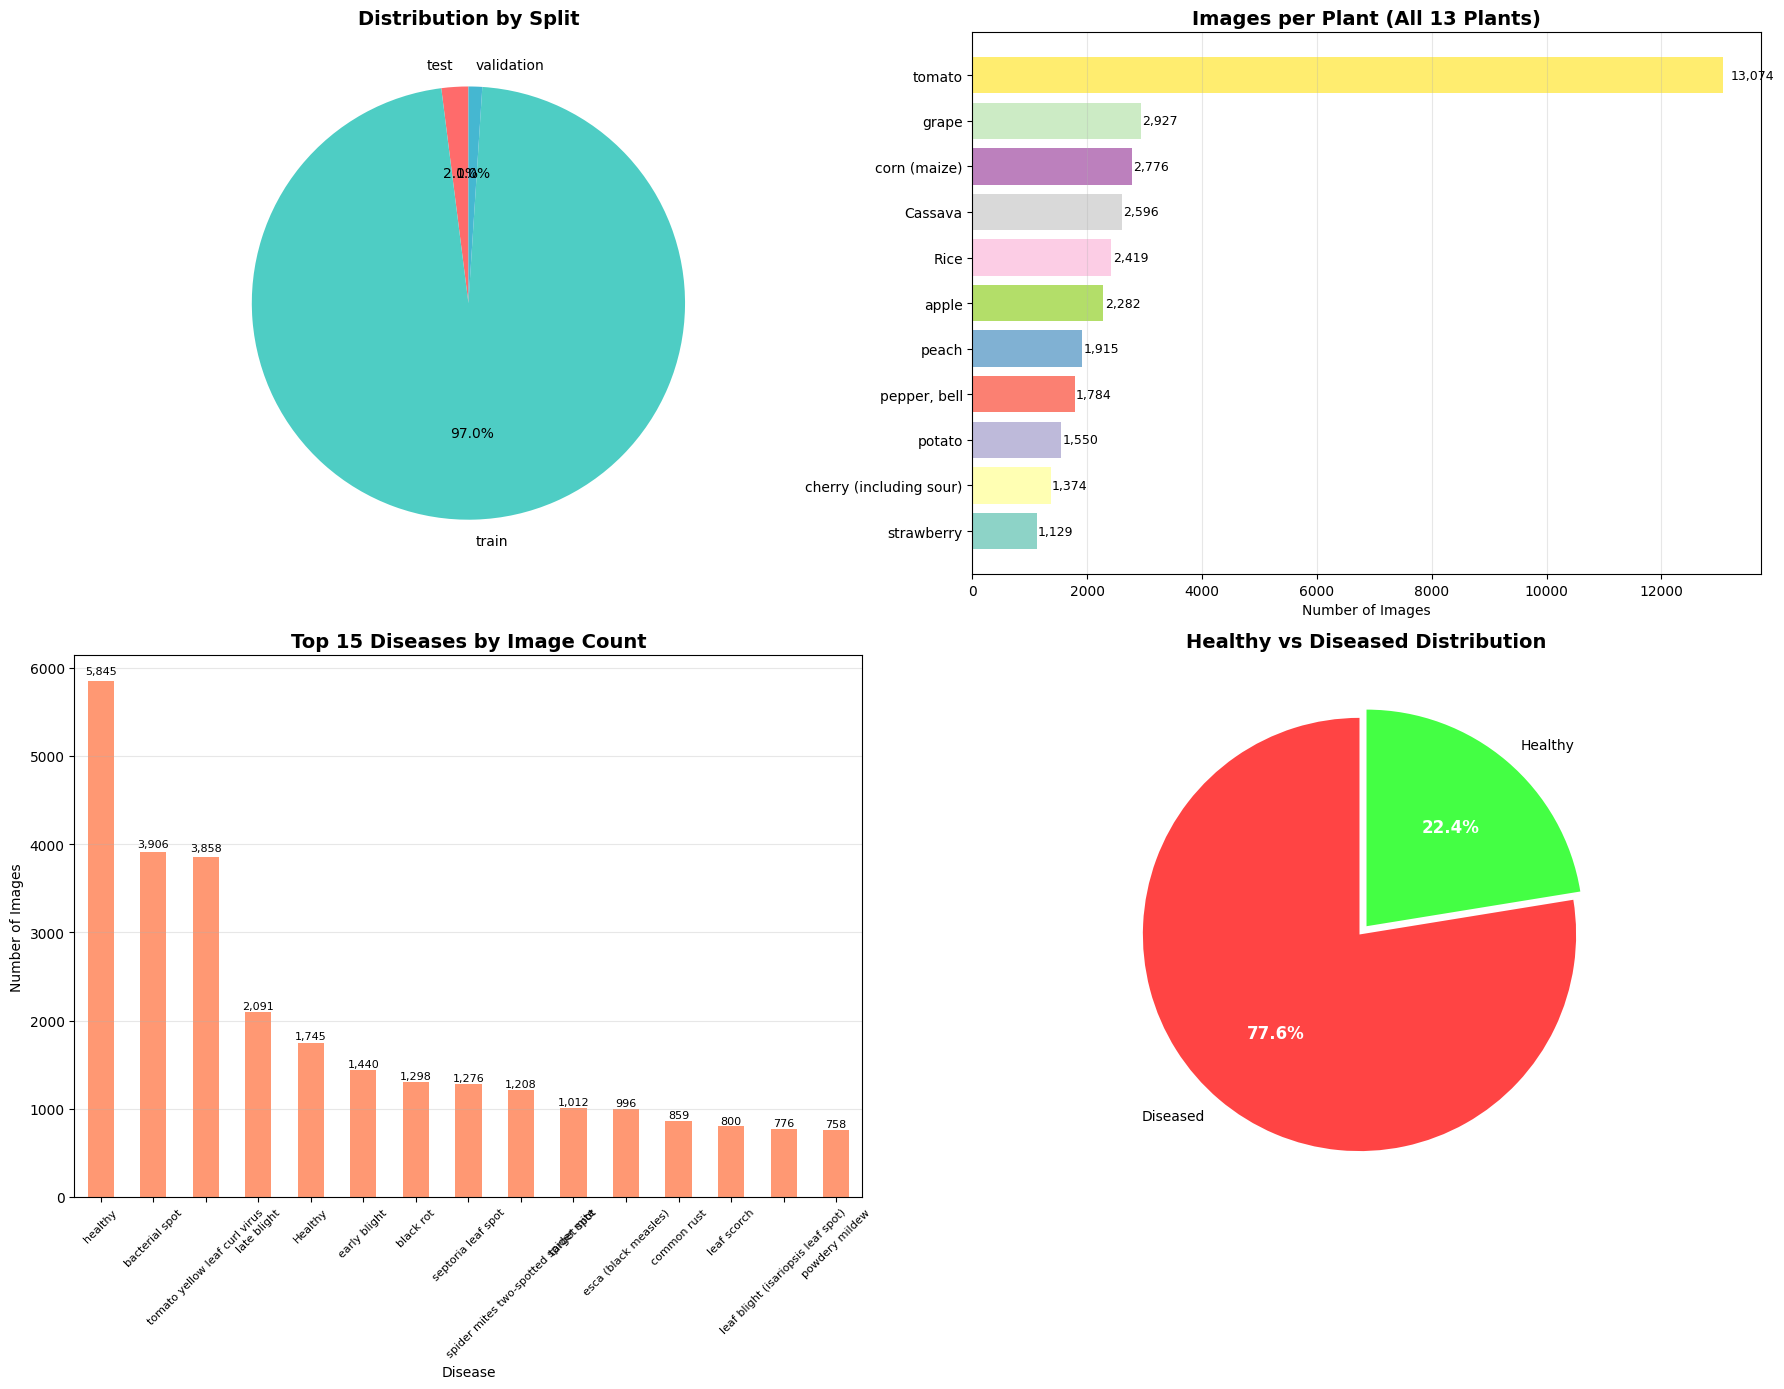


COMPLETE PLANT BREAKDOWN (All 13 Plants)
 1. tomato                    : 13,074 images ( 38.7%) | 10 diseases |  8.7% healthy
 2. grape                     :  2,927 images (  8.7%) |  4 diseases | 10.4% healthy
 3. corn (maize)              :  2,776 images (  8.2%) |  4 diseases | 30.2% healthy
 4. Cassava                   :  2,596 images (  7.7%) |  5 diseases | 25.9% healthy
 5. Rice                      :  2,419 images (  7.2%) |  4 diseases | 44.3% healthy
 6. apple                     :  2,282 images (  6.7%) |  4 diseases | 51.8% healthy
 7. peach                     :  1,915 images (  5.7%) |  2 diseases | 13.6% healthy
 8. pepper, bell              :  1,784 images (  5.3%) |  2 diseases | 59.7% healthy
 9. potato                    :  1,550 images (  4.6%) |  3 diseases |  7.1% healthy
10. cherry (including sour)   :  1,374 images (  4.1%) |  2 diseases | 44.8% healthy
11. strawberry                :  1,129 images (  3.3%) |  2 diseases | 29.1% healthy

 SUMMARY STATISTICS:
 

In [19]:
data = []
root = Path(data_path) / "image data" if (Path(data_path) / "image data").exists() else Path(data_path)

for split in ['train', 'test', 'validation']:
    split_path = root / split
    if split_path.exists():
        for plant in os.listdir(split_path):
            plant_path = split_path / plant
            if plant_path.is_dir():
                for disease in os.listdir(plant_path):
                    disease_path = plant_path / disease
                    if disease_path.is_dir():
                        image_count = len([f for f in os.listdir(disease_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp'))])
                        is_healthy = 'healthy' in disease.lower() # Assuming 'healthy' is in the folder name for healthy plants
                        data.append([split, plant, disease, image_count, is_healthy])

df = pd.DataFrame(data, columns=['split', 'plant', 'disease', 'count', 'is_healthy'])
display(df.head())

def plot_complete_hierarchy(df):
    """Create comprehensive hierarchical plots showing all plants and diseases"""

    # Create larger figure to accommodate all data
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # 1. Split distribution
    split_counts = df.groupby('split')['count'].sum()
    colors_splits = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    axes[0,0].pie(split_counts.values, labels=split_counts.index, autopct='%1.1f%%',
                  colors=colors_splits, startangle=90)
    axes[0,0].set_title('Distribution by Split', fontsize=14, fontweight='bold')

    # 2. ALL Plants distribution (horizontal bar chart for better readability)
    plant_counts = df.groupby('plant')['count'].sum().sort_values(ascending=True)

    # Create color map for plants
    colors_plants = plt.cm.Set3(np.linspace(0, 1, len(plant_counts)))

    bars = axes[0,1].barh(range(len(plant_counts)), plant_counts.values, color=colors_plants)
    axes[0,1].set_yticks(range(len(plant_counts)))
    axes[0,1].set_yticklabels(plant_counts.index, fontsize=10)
    axes[0,1].set_title('Images per Plant (All 13 Plants)', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Number of Images')
    axes[0,1].grid(axis='x', alpha=0.3)

    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[0,1].text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                      f'{int(width):,}', ha='left', va='center', fontsize=9)

    # 3. Top diseases distribution (show more diseases)
    disease_counts = df.groupby('disease')['count'].sum().sort_values(ascending=False).head(15)

    # Rotate the bar chart and make it more readable
    disease_counts.plot(kind='bar', ax=axes[1,0], color='coral', alpha=0.8)
    axes[1,0].set_title('Top 15 Diseases by Image Count', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Disease')
    axes[1,0].set_ylabel('Number of Images')
    axes[1,0].tick_params(axis='x', rotation=45, labelsize=8)
    axes[1,0].grid(axis='y', alpha=0.3)

    # Add value labels on top of bars
    for i, (disease, count) in enumerate(disease_counts.items()):
        axes[1,0].text(i, count + count*0.01, f'{int(count):,}',
                      ha='center', va='bottom', fontsize=8, rotation=0)

    # 4. Healthy vs Diseased
    health_counts = df.groupby('is_healthy')['count'].sum()
    colors_health = ['#FF4444', '#44FF44']  # Red for diseased, green for healthy
    labels_health = ['Diseased', 'Healthy']

    wedges, texts, autotexts = axes[1,1].pie(health_counts.values,
                                           labels=labels_health,
                                           autopct='%1.1f%%',
                                           colors=colors_health,
                                           startangle=90,
                                           explode=(0.05, 0))  # Slightly separate slices

    axes[1,1].set_title('Healthy vs Diseased Distribution', fontsize=14, fontweight='bold')

    # Make percentage text more readable
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)

    plt.tight_layout()
    plt.show()

    # Additional detailed breakdown
    print("\n" + "="*80)
    print("COMPLETE PLANT BREAKDOWN (All 13 Plants)")
    print("="*80)

    total_images = df['count'].sum()

    for i, (plant, count) in enumerate(plant_counts.sort_values(ascending=False).items(), 1):
        percentage = (count / total_images) * 100

        # Get disease count for this plant
        plant_diseases = df[df['plant'] == plant]['disease'].nunique()

        # Get healthy percentage for this plant
        plant_data = df[df['plant'] == plant]
        healthy_count = plant_data[plant_data['is_healthy'] == True]['count'].sum()
        healthy_pct = (healthy_count / count) * 100 if count > 0 else 0

        print(f"{i:2d}. {plant:<25} : {count:>6,} images ({percentage:5.1f}%) | "
              f"{plant_diseases:2d} diseases | {healthy_pct:4.1f}% healthy")

    print(f"\n SUMMARY STATISTICS:")
    print(f"   Total Plants: {plant_counts.nunique()}")
    print(f"   Total Images: {total_images:,}")
    print(f"   Average per Plant: {total_images/len(plant_counts):,.0f} images")
    print(f"   Largest Plant: {plant_counts.max():,} images ({plant_counts.idxmax()})")
    print(f"   Smallest Plant: {plant_counts.min():,} images ({plant_counts.idxmin()})")
    print(f"   Imbalance Ratio: {plant_counts.max()/plant_counts.min():.1f}x")

# Execute both functions
print("Creating complete hierarchy visualization...")
plot_complete_hierarchy(df)

##Normalization and Spleat data






>  Individul Standartitation Normalization (This type of normalithation normalizede itch photo by individual harateristik with average value of each image: 0 and range [-6,6]. It help stantarizate iach photo to same spector characteristik. That will help crearly see spcific paterns on photo and recocnize them after)



In this cell we reorder train/validation/test proporthionaly for each folder  with photo for exthemle:
-test
--plant name
---disease name

In [20]:
from pathlib import Path
import os, shutil
import numpy as np

# If there is "image data" folder, use it; otherwise use root
ROOT = Path(data_path) / "image data" if (Path(data_path) / "image data").exists() else Path(data_path)

# Fractions for splits (must sum to 1.0)
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.80, 0.10, 0.10
assert abs(TRAIN_FRAC + VAL_FRAC + TEST_FRAC - 1.0) < 1e-6

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# Allowed image extensions
EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.webp', '.tif', '.tiff'}

# Source split folders we will read from (do NOT delete them until the end)
SOURCE_SPLITS = ["train", "validation", "val", "dev", "test", "testing"]

# Staging root to build new splits safely
STAGING = ROOT / "_rebuilt_splits"

def safe_rmtree(p: Path):
    if p.exists():
        shutil.rmtree(p)

# 1) Collect all images from any existing split (without modifying current folders)
groups = {}  # key=(plant, disease) -> list of file paths

def add_image(plant, disease, img_path):
    groups.setdefault((plant, disease), []).append(img_path)

for split in SOURCE_SPLITS:
    split_dir = ROOT / split
    if not split_dir.exists():
        continue
    for plant_dir in split_dir.iterdir():
        if not plant_dir.is_dir():
            continue
        plant = plant_dir.name
        for disease_dir in plant_dir.iterdir():
            if not disease_dir.is_dir():
                continue
            disease = disease_dir.name
            for p in disease_dir.rglob("*"):
                if p.is_file() and p.suffix.lower() in EXTS:
                    add_image(plant, disease, p)

total_collected = sum(len(v) for v in groups.values())
print(f"Collected {total_collected} images across {len(groups)} (plant,disease) groups.")
if total_collected == 0:
    raise RuntimeError(f"No images found under {ROOT}.")

# 2) Build NEW splits into STAGING (copy files). We do not touch original splits yet.
safe_rmtree(STAGING)
(STAGING / "train").mkdir(parents=True, exist_ok=True)
(STAGING / "validation").mkdir(parents=True, exist_ok=True)
(STAGING / "test").mkdir(parents=True, exist_ok=True)

def split_counts(n, f_train, f_val, f_test):
    """Return counts for train/val/test, with rounding safety."""
    n_train = int(np.floor(n * f_train))
    n_val   = int(np.floor(n * f_val))
    n_test  = n - n_train - n_val
    if n_test < 0:
        n_test = 0
        n_val = n - n_train
    return n_train, n_val, n_test

copied = {"train":0, "validation":0, "test":0}

for (plant, disease), files in sorted(groups.items()):
    files = list(files)
    rng.shuffle(files)
    n_train, n_val, n_test = split_counts(len(files), TRAIN_FRAC, VAL_FRAC, TEST_FRAC)

    subsets = {
        "train": files[:n_train],
        "validation": files[n_train:n_train+n_val],
        "test": files[n_train+n_val:]
    }

    for split_name, subset in subsets.items():
        dest_dir = STAGING / split_name / plant / disease
        dest_dir.mkdir(parents=True, exist_ok=True)
        for src in subset:
            # Copy to staging (do not modify originals yet)
            dst = dest_dir / Path(src).name
            i = 1
            while dst.exists():
                dst = dest_dir / f"{Path(src).stem}_{i}{Path(src).suffix}"
                i += 1
            shutil.copy2(str(src), str(dst))
            copied[split_name] += 1

print(f"Staging copies -> train: {copied['train']}, val: {copied['validation']}, test: {copied['test']}")

# 3) If staging succeeded, remove OLD final splits and move staging splits into place
for final_split in ["train", "validation", "test"]:
    safe_rmtree(ROOT / final_split)  # remove old target split completely
    # move freshly built split from staging into ROOT
    shutil.move(str(STAGING / final_split), str(ROOT / final_split))

# 4) Cleanup staging root (now empty or only with non-moved dirs)
safe_rmtree(STAGING)

# 5) (Optional) Remove legacy source split folders that are not final names
#     If you want to keep backups, comment this block out.
for legacy in ["val", "dev", "testing"]:
    safe_rmtree(ROOT / legacy)

# 6) Print a simple summary and verify new structure counts
def count_images(split_root: Path):
    """Count images under split_root recursively."""
    total = 0
    for p in split_root.rglob("*"):
        if p.is_file() and p.suffix.lower() in EXTS:
            total += 1
    return total

print("\nRebuild COMPLETE.")
print("Final counts:",
      "train:", count_images(ROOT / "train"),
      "| validation:", count_images(ROOT / "validation"),
      "| test:", count_images(ROOT / "test"))


Collected 33826 images across 42 (plant,disease) groups.
Staging copies -> train: 27045, val: 3364, test: 3417

Rebuild COMPLETE.
Final counts: train: 27045 | validation: 3364 | test: 3417


Heare we creat tf.data data set with standart normalithation

In [21]:
import tensorflow as tf
from pathlib import Path

ROOT = Path(data_path) / "image data" if (Path(data_path) / "image data").exists() else Path(data_path)

# Collect (path,label) pairs; label = plant name
def collect_split(split):
    paths, plants, diseases = [], [], []
    split_dir = ROOT / split
    if not split_dir.exists():
        return paths, plants, diseases
    for plant_dir in split_dir.iterdir():
        if not plant_dir.is_dir():
            continue
        plant = plant_dir.name
        for disease_dir in plant_dir.iterdir():
            if not disease_dir.is_dir():
                continue
            disease = disease_dir.name
            for p in disease_dir.rglob("*"):
                if p.is_file() and p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp",".tif",".tiff"}:
                    paths.append(str(p))
                    plants.append(plant)
                    diseases.append(disease)
    return paths, plants, diseases

train_paths, train_plants, train_diseases = collect_split("train")
val_paths,   val_plants, val_diseases  = collect_split("validation")
test_paths,  test_plants, test_diseases  = collect_split("test")

# Build label mapping plantsload_image
class_names_plants = sorted(set(train_plants + val_plants + test_plants))
plants_to_index = {name:i for i,name in enumerate(class_names_plants)}
train_plants = [plants_to_index[x] for x in train_plants]
val_plants  = [plants_to_index[x] for x in val_plants]
test_plants  = [plants_to_index[x] for x in test_plants]

print(f"Classes plants: {len(class_names_plants)} | Train {len(train_paths)} | Val {len(val_paths)} | Test {len(test_paths)}")

# Build label mapping plants
class_names_disease = sorted(set(train_diseases + val_diseases + test_diseases))
deseases_to_index = {name:i for i,name in enumerate(class_names_disease)}
train_diseases = [deseases_to_index[x] for x in train_diseases]
val_diseases   = [deseases_to_index[x] for x in val_diseases]
test_diseases  = [deseases_to_index[x] for x in test_diseases]

print(f"Classes deseases: {len(class_names_disease)} | Train {len(train_paths)} | Val {len(val_paths)} | Test {len(test_paths)}")

# Parameters
IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE = 256, 256, 32

def imagenet_normalize(image):
    # Apply per-image standardization (zero mean, unit variance per image)
    return tf.image.per_image_standardization(image * 255.0)

def load_image(image_path, plants_label, diseases_label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0
    img = imagenet_normalize(img)
    return img, (plants_label, diseases_label)

# Build datasets
 # 0 if plants_label 1 if diseases_label 2 multi
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_plants, train_diseases)).map(load_image, num_parallel_calls=tf.data.AUTOTUNE) #.map(lambda img, labels: (img, labels[1]))
train_ds = train_ds.shuffle(2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_plants, val_diseases)).map(load_image, num_parallel_calls=tf.data.AUTOTUNE) #.map(lambda img, labels: (img, labels[1]))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_plants, test_diseases)).map(load_image, num_parallel_calls=tf.data.AUTOTUNE) #.map(lambda img, labels: (img, labels[1]))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



# Quick sanity check
for name, ds in [("Train", train_ds), ("Validation", val_ds), ("Test", test_ds)]:
    try:
        imgs, lbl = next(iter(ds))
        # imgs, (lblp, lbld) = next(iter(ds)) #if we use  to labeles togater
        #print(f"\n{name} batch: images {imgs.shape} | labels {lbl.shape} | dtype {imgs.dtype}")
        mn = tf.reduce_min(imgs).numpy().item()
        mx = tf.reduce_max(imgs).numpy().item()
        print(f"{name} value range after per_image_standardization: [{mn:.3f}, {mx:.3f}]")
    except StopIteration:
        print(f"\n{name}: EMPTY")


Classes plants: 11 | Train 27045 | Val 3364 | Test 3417
Classes deseases: 28 | Train 27045 | Val 3364 | Test 3417
Train value range after per_image_standardization: [-3.636, 4.086]
Validation value range after per_image_standardization: [-2.744, 3.538]
Test value range after per_image_standardization: [-3.458, 3.719]


In [22]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)))>


#Weights and lost funcktions

##Class weights

Becauuse we have strong inbalanse in ower data we diside to give proprotional to number of photo in ich class weight

In [23]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

weights_plants = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_plants),
    y=train_plants
)
class_weights_plants = dict(enumerate(weights_plants))

for idx, name in enumerate(class_weights_plants):
    print(f"Class {idx:2d} ({name:2d}) -> weight {class_weights_plants[idx]:.3f}")

Class  0 ( 0) -> weight 1.185
Class  1 ( 1) -> weight 1.272
Class  2 ( 2) -> weight 1.348
Class  3 ( 3) -> weight 2.239
Class  4 ( 4) -> weight 1.107
Class  5 ( 5) -> weight 1.051
Class  6 ( 6) -> weight 1.605
Class  7 ( 7) -> weight 1.723
Class  8 ( 8) -> weight 1.983
Class  9 ( 9) -> weight 2.723
Class 10 (10) -> weight 0.235


In [24]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# where train_labels_disease is an np.array of disease labels for the train
# class_names_disease is a list of disease names (in the correct order)

weights_disease = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_diseases),
    y=train_diseases
)
class_weights_disease = dict(enumerate(weights_disease))

for idx, name in enumerate(class_names_disease):
    print(f"Disease {idx:2d} ({name:35s}) -> weight {class_weights_disease[idx]:.3f}")


Disease  0 (Bacterial Blight (CBB)             ) -> weight 2.583
Disease  1 (Brown Streak Disease (CBSD)        ) -> weight 2.166
Disease  2 (BrownSpot                          ) -> weight 3.209
Disease  3 (Green Mottle (CGM)                 ) -> weight 2.569
Disease  4 (Healthy                            ) -> weight 0.692
Disease  5 (Hispa                              ) -> weight 2.963
Disease  6 (LeafBlast                          ) -> weight 2.151
Disease  7 (Mosaic Disease (CMD)               ) -> weight 2.841
Disease  8 (apple scab                         ) -> weight 2.661
Disease  9 (bacterial spot                     ) -> weight 0.309
Disease 10 (black rot                          ) -> weight 0.931
Disease 11 (cedar apple rust                   ) -> weight 6.075
Disease 12 (cercospora leaf spot gray leaf spot) -> weight 3.263
Disease 13 (common rust                        ) -> weight 1.406
Disease 14 (early blight                       ) -> weight 0.838
Disease 15 (esca (black m

##Houdini Loss



> Houdini loss function — this function simultaneously uses stochastic probabilities and standard distance metrics or gradients (Houdini = P(score_difference > threshold) × task_loss). It helps to evaluate better both distance factors and predictions, and gives better weights also in difficult cases and even in black boxes. This function was created in Israel.


In [25]:
# Houdini Loss

import math
import torch

def _normal_cdf(x: torch.Tensor) -> torch.Tensor:
    """Standard normal CDF using erf (stable and differentiable)."""
    return 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

@torch.no_grad()
def _ensure_long(t: torch.Tensor) -> torch.Tensor:
    """Ensure target dtype is long and detached (no grad)."""
    return t.long()

def houdini_loss(logits: torch.Tensor,
                 target: torch.Tensor,
                 sigma: float = 1.0,
                 class_weight: torch.Tensor | None = None) -> torch.Tensor:
    """
    Weighted Houdini margin loss (per-sample weighting).
    If class_weight is provided (Tensor[C]), scales each sample by class_weight[y_i].

    Args:
        logits: [B, C] raw scores
        target: [B] class indices
        sigma:  margin temperature
        class_weight: [C] class weights aligned to 'classes' order

    Returns:
        Scalar loss (mean over batch)
    """
    # AMP-safe: compute in float32 regardless of autocast
    with torch.cuda.amp.autocast(enabled=False):
        z = logits.float()
        y = _ensure_long(target)

        # true-class score s_y
        s_y = z.gather(1, y.view(-1,1)).squeeze(1)  # [B]

        # best non-true score s_other
        mask = torch.ones_like(z, dtype=torch.bool)
        mask.scatter_(1, y.view(-1,1), False)
        s_other = z.masked_fill(~mask, float('-inf')).amax(dim=1)  # [B]

        # margin (want negative)
        m = (s_other - s_y) / float(sigma)  # [B]

        # Φ(m) ∈ (0,1); higher when margin is positive (worse)
        base = _normal_cdf(m)  # [B]

        # optional per-sample scaling by class weights
        if class_weight is not None:
            w = class_weight.to(z.device, dtype=base.dtype).gather(0, y)  # [B]
            base = base * w

        return base.mean()


#Train

##CNN(convolution neyro networkong)

Two experiments on 50% subset, 7 epochs,
  A) Houdini-style margin loss
  B) CrossEntropyLoss + class_weights
CrossEntropyLoss mesure distanse bitween two probability distribution between real probabbility destribution: p and predicted probobility distrebiton of model: q, H(p,q) = -Σ p(x) log q(x).

In most cases we dont need masure spcifik wites for Houdini because the Houdini weiths depends on the difference between the correct class and the "strongest" class

In [26]:
# =================== UNIVERSAL BENCHMARK (plant vs disease) ===================
# Compares Houdini vs CrossEntropy(+class weights) on chosen label granularity.
# - Pluggable metrics: pass a list of callables (y_true, y_pred, y_proba, classes)->dict
# - Supports user-provided class_weights dicts {class_name: weight}
# - Keeps the best epoch by val macro-F1; returns predictions/probas for later analysis.

import os, time, copy, math, warnings
from pathlib import Path
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# ---------------- User inputs ----------------
ROOT = Path(data_path) / "image data" if (Path(data_path) / "image data").exists() else Path(data_path)

SUBSAMPLE_FRAC = 0.10     # exact 20% of train
EPOCHS         = 4       # keep tag text consistent below
BATCH_SIZE     = 64
NUM_WORKERS    = 2
LR             = 3e-4
WEIGHT_DECAY   = 1e-4
RANDOM_SEED    = 42
USE_REAL_HOUDINI = True   # if you already defined global houdini_loss(logits,y)

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# ---------------- Per-image standardization ----------------
def per_image_standardization_torch(x: torch.Tensor) -> torch.Tensor:
    """Standardize a single image tensor channel-wise after scaling to [0,255]."""
    x255 = x * 255.0
    mean = x255.mean()
    var  = x255.var(unbiased=False)
    std  = torch.sqrt(var + 1e-12)
    adjusted_std = torch.maximum(std, torch.tensor(1.0 / math.sqrt(x255.numel()), device=x.device, dtype=x.dtype))
    return (x255 - mean) / adjusted_std

class PathsDataset(Dataset):
    """Lightweight dataset built from arrays of paths and numeric labels."""
    def __init__(self, paths_np, labels_np, resize_hw=(256,256), augment=False):
        self.paths_np = paths_np
        self.labels_np = labels_np
        self.resize = transforms.Resize(resize_hw, interpolation=transforms.InterpolationMode.BILINEAR)
        self.augs = None
        if augment:
            self.augs = transforms.RandomOrder([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(0.2,0.2,0.2,0.03),
            ])
    def __len__(self): return len(self.paths_np)
    def __getitem__(self,i):
        p = self.paths_np[i]; y = int(self.labels_np[i])
        img = Image.open(p).convert("RGB")
        img = self.resize(img)
        x = transforms.functional.to_tensor(img)
        if self.augs is not None:
            x_pil = transforms.functional.to_pil_image(x)
            x_pil = self.augs(x_pil)
            x = transforms.functional.to_tensor(x_pil)
        x = per_image_standardization_torch(x)
        return x, y

# ---------------- Split collection with label_mode ----------------
EXTS = {'.jpg','.jpeg','.png','.bmp','.webp','.tif','.tiff'}

def collect_split(split, label_mode="plant"):
    """
    label_mode='plant'   -> label = plant_dir.name
    label_mode='disease' -> label = disease_dir.name  (merge same-named diseases)
    """
    assert label_mode in {"plant","disease"}
    paths, labels = [], []
    split_dir = ROOT / split
    if not split_dir.exists():
        return paths, labels
    for plant_dir in sorted(p for p in split_dir.iterdir() if p.is_dir()):
        plant = plant_dir.name
        for disease_dir in sorted(p for p in plant_dir.iterdir() if p.is_dir()):
            disease = disease_dir.name
            for f in disease_dir.rglob("*"):
                if f.is_file() and f.suffix.lower() in EXTS:
                    paths.append(str(f))
                    labels.append(plant if label_mode=="plant" else disease)
    return paths, labels

def make_loaders(label_mode="plant", augment_train=False):
    """Build datasets/dataloaders + numeric encodings for a chosen label granularity."""
    tr_p, tr_l_str = collect_split("train", label_mode)
    va_p, va_l_str = collect_split("validation", label_mode)
    te_p, te_l_str = collect_split("test", label_mode)

    classes = sorted(set(tr_l_str + va_l_str + te_l_str))
    label_to_index = {c:i for i,c in enumerate(classes)}
    tr_l = np.array([label_to_index[s] for s in tr_l_str], dtype=np.int64)
    va_l = np.array([label_to_index[s] for s in va_l_str], dtype=np.int64)
    te_l = np.array([label_to_index[s] for s in te_l_str], dtype=np.int64)

    tr_p = np.array(tr_p); va_p = np.array(va_p); te_p = np.array(te_p)

    train_ds_full = PathsDataset(tr_p, tr_l, augment=augment_train)
    val_ds        = PathsDataset(va_p, va_l)
    test_ds       = PathsDataset(te_p, te_l) if len(te_p) else None

    # exact 20% subset
    n_train = len(train_ds_full)
    k = max(1, int(n_train * SUBSAMPLE_FRAC))
    idx = np.arange(n_train)
    rng = np.random.default_rng(RANDOM_SEED); rng.shuffle(idx)
    train_indices = idx[:k]
    train_ds = Subset(train_ds_full, train_indices)

    pin_mem = (device.type=='cuda')
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=pin_mem)
    val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_mem)
    test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_mem) if test_ds else None

    return dict(
        classes=classes, C=len(classes),
        train_ds_full=train_ds_full, train_ds=train_ds, train_indices=train_indices,
        val_ds=val_ds, test_ds=test_ds,
        train_dl=train_dl, val_dl=val_dl, test_dl=test_dl
    )

# ---------------- Model / metrics / loss helpers ----------------
def make_resnet18(num_classes:int)->nn.Module:
    """ResNet-18 backbone with a light dropout on the head."""
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    m.fc = nn.Sequential(nn.Dropout(0.2), nn.Linear(m.fc.in_features, num_classes))
    return m.to(device)

@torch.no_grad()
def eval_split(model, dl, criterion=None, need_probs:bool=True):
    """Evaluate on a dataloader; optionally collect probabilities for extra metrics."""
    model.eval()
    tot=corr=0; loss_sum=0.0
    y_true=[]; y_pred=[]; y_prob=[]
    for x,y in dl:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        if criterion is not None:
            loss_sum += criterion(logits,y).item()*y.size(0)
        p = logits.argmax(1)
        corr += (p==y).sum().item(); tot += y.size(0)
        y_true.append(y.cpu().numpy()); y_pred.append(p.cpu().numpy())
        if need_probs:
            y_prob.append(torch.softmax(logits, dim=1).cpu().numpy())
    if tot==0:
        return dict(
            loss=0.0, acc=0.0, f1_macro=0.0, f1_weighted=0.0,
            y_true=np.array([]), y_pred=np.array([]), y_proba=np.array([])
        )
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    y_proba = np.concatenate(y_prob) if (need_probs and len(y_prob)) else None
    acc = corr/tot
    f1m = f1_score(y_true,y_pred,average='macro',zero_division=0)
    f1w = f1_score(y_true,y_pred,average='weighted',zero_division=0)
    loss_avg = loss_sum/tot if criterion is not None else 0.0
    return dict(loss=loss_avg, acc=acc, f1_macro=f1m, f1_weighted=f1w,
                y_true=y_true, y_pred=y_pred, y_proba=y_proba)

def align_weights_from_dict(classes, weights_dict:dict|None):
    """
    Align a user-provided dict {class_name: weight} to a torch tensor in `classes` order.
    Warn if there are missing or extra keys. If missing, fallback to 1.0.
    """
    if not weights_dict:
        return None
    miss = [c for c in classes if c not in weights_dict]
    extra = [k for k in weights_dict.keys() if k not in classes]
    if miss:
        warnings.warn(f"[class weights] missing classes: {miss}; using 1.0 for them")
    if extra:
        warnings.warn(f"[class weights] extra keys not in classes: {extra} (ignored)")
    arr = np.array([weights_dict.get(c, 1.0) for c in classes], dtype=np.float32)
    return torch.tensor(arr, device=device)
"""
class HoudiniMarginLoss(nn.Module):
    #Self-contained Houdini-style margin loss (if you don't use your own)
    def __init__(self, tau: float = 1.0):
        super().__init__(); self.tau=tau; self.sigmoid=nn.Sigmoid()
    def forward(self, logits, y):
        s_true = logits.gather(1, y.view(-1,1))
        mask = torch.ones_like(logits, dtype=torch.bool); mask.scatter_(1, y.view(-1,1), False)
        max_other = logits.masked_fill(~mask, float('-inf')).amax(dim=1, keepdim=True)
        margin = (max_other - s_true)/self.tau
        return self.sigmoid(margin).mean()
"""
def run_experiment_pair(label_mode="plant",
                        class_weights_dict:dict|None=None,
                        metrics_fns:list|None=None,
                        augment_train:bool=False):
    """
    Run two training loops on the same split/subset:
      - 'houdini' : your global houdini_loss if available (or local fallback)
      - 'cew'     : CrossEntropy with aligned class weights (if provided)
    metrics_fns: list of callables (y_true, y_pred, y_proba, classes) -> dict
    Returns a dict with per-mode summaries, predictions, and models.
    """
    # loaders
    bundle = make_loaders(label_mode=label_mode, augment_train=augment_train)
    classes = bundle["classes"]; C=bundle["C"]
    val_dl=bundle["val_dl"]; test_dl=bundle["test_dl"]

    # class weights for CE aligned to class order
    CE_WEIGHTS = align_weights_from_dict(classes, class_weights_dict)

    results = {}

    for mode in ("houdini","cew"):
        model = make_resnet18(C)
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
    mode='max',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    #verbose=True
)
        scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
        pct = int(SUBSAMPLE_FRAC * 100)
        if mode=="houdini":
            if USE_REAL_HOUDINI and ('houdini_loss' in globals()):
                def criterion(logits,y): return houdini_loss(logits,y)  # your custom
            else:
                criterion = HoudiniMarginLoss(tau=1.0)
            tag = f"{label_mode.upper()} | Houdini_{pct}p_{EPOCHS}e"
        else:
            criterion = nn.CrossEntropyLoss(weight=CE_WEIGHTS) if CE_WEIGHTS is not None else nn.CrossEntropyLoss()
            tag = f"{label_mode.upper()} | CE+Weights_{pct}p_{EPOCHS}e" if CE_WEIGHTS is not None else f"{label_mode.upper()} | CE_20p_{EPOCHS}e"

        best_f1m=-1.0; best_state=None; best_epoch=-1

        def train_one_epoch():
            """One training epoch with AMP."""
            model.train()
            tot=corr=0; loss_sum=0.0
            for x,y in bundle["train_dl"]:
                x,y = x.to(device), y.to(device)
                optimizer.zero_grad(set_to_none=True)
                with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                    logits = model(x); loss = criterion(logits,y)
                scaler.scale(loss).backward()
                scaler.step(optimizer); scaler.update()
                with torch.no_grad():
                    p = logits.argmax(1); corr += (p==y).sum().item(); tot += y.size(0); loss_sum += loss.item()*y.size(0)
            return (loss_sum/max(1,tot), corr/max(1,tot))

        # --- train loop
        for epoch in range(1,EPOCHS+1):
            t0=time.time()
            tr_loss, tr_acc = train_one_epoch()
            val_stats = eval_split(model, val_dl, criterion, need_probs=True)
            # после val_stats = eval_split(...)
            scheduler.step(val_stats['f1_macro'])  # для mode='max'

            print(f"[{tag}] epoch {epoch:02d} | train acc {tr_acc:.3f} loss {tr_loss:.3f} | "
                  f"val acc {val_stats['acc']:.3f} f1m {val_stats['f1_macro']:.3f} loss {val_stats['loss']:.3f} | time {time.time()-t0:.1f}s")
            if val_stats['f1_macro'] > best_f1m:
                best_f1m = float(val_stats['f1_macro']); best_epoch=epoch; best_state=copy.deepcopy(model.state_dict())

        if best_state is not None:
            model.load_state_dict(best_state)

        # --- final evals
        val_stats  = eval_split(model, val_dl,  criterion, need_probs=True)
        test_stats = eval_split(model, test_dl, criterion, need_probs=True) if test_dl is not None else None

        # --- built-in prints
        print("\nValidation classification report:")
        print(classification_report(val_stats['y_true'], val_stats['y_pred'], target_names=classes, zero_division=0))
        if test_stats is not None:
            print("Test classification report:")
            print(classification_report(test_stats['y_true'], test_stats['y_pred'], target_names=classes, zero_division=0))

        # --- user metrics (plug-in)
        extra_val_metrics = {}
        extra_test_metrics = {}
        if metrics_fns:
            for fn in metrics_fns:
                try:
                    extra_val_metrics |= fn(val_stats['y_true'], val_stats['y_pred'], val_stats['y_proba'], classes)
                    if test_stats is not None:
                        extra_test_metrics |= fn(test_stats['y_true'], test_stats['y_pred'], test_stats['y_proba'], classes)
                except Exception as e:
                    warnings.warn(f"[metrics] '{getattr(fn,'__name__',str(fn))}' failed: {e}")

        summary = dict(
            label_mode=label_mode, tag=tag, best_epoch=best_epoch,
            final_val_f1_macro=float(val_stats['f1_macro']),
            final_val_loss=float(val_stats['loss']),
            final_val_acc=float(val_stats['acc']),
            final_test_f1_macro=float(test_stats['f1_macro']) if test_stats is not None else float('nan'),
            final_test_acc=float(test_stats['acc']) if test_stats is not None else float('nan'),
            extra_val_metrics=extra_val_metrics,
            extra_test_metrics=extra_test_metrics
        )

        results[mode] = dict(
            summary=summary,
            model=model,
            classes=classes,
            val_stats=val_stats,
            test_stats=test_stats
        )

    # comparison print
    print(f"\n=== COMPARISON [{label_mode.upper()}] (20% / {EPOCHS} epochs) ===")
    h = results["houdini"]["summary"]; c = results["cew"]["summary"]
    show = ['best_epoch','final_val_f1_macro','final_val_loss','final_val_acc','final_test_f1_macro','final_test_acc']
    print("Houdini: ", {k:h[k] for k in show})
    print("CE+Wght:", {k:c[k] for k in show})
    return results

# ---------------- Example: wrap your custom metrics ----------------
# Define adapters for your already-written metrics. Each should return a dict.
def metric_confmat(y_true, y_pred, y_proba, classes):
    """Return confusion matrix as a flattened dict for logging (optional)."""
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
    return {"confusion_matrix": cm.tolist()}  # keep it JSON-serializable

# If you have your own functions, pass them here (example):
# metrics_list = [your_metric_fn1, your_metric_fn2, metric_confmat]
metrics_list = [metric_confmat]

# ---------------- RUNS ----------------
# IMPORTANT: pass the corresponding weights dict for each label_mode.
#   - class_weights_plants:   {plant_name: weight}
#   - class_weights_diseases: {disease_name: weight}
#
# Example (uncomment when you have both dicts in scope):
res_plant   = run_experiment_pair(label_mode="plant",
                                   class_weights_dict=class_weights_plants,
                                   metrics_fns=metrics_list,
                                   augment_train=False)
res_disease = run_experiment_pair(label_mode="disease",
                                   class_weights_dict=class_weights_disease,
                                   metrics_fns=metrics_list,
                                   augment_train=False)


Device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /content/kagglehub_cache_1759094814/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


[PLANT | Houdini_10p_4e] epoch 01 | train acc 0.888 loss 0.122 | val acc 0.951 f1m 0.931 loss 0.051 | time 11.1s
[PLANT | Houdini_10p_4e] epoch 02 | train acc 0.984 loss 0.021 | val acc 0.971 f1m 0.964 loss 0.036 | time 9.6s
[PLANT | Houdini_10p_4e] epoch 03 | train acc 0.988 loss 0.015 | val acc 0.979 f1m 0.973 loss 0.024 | time 10.4s
[PLANT | Houdini_10p_4e] epoch 04 | train acc 0.991 loss 0.010 | val acc 0.976 f1m 0.964 loss 0.028 | time 10.9s

Validation classification report:
                         precision    recall  f1-score   support

                Cassava       0.94      1.00      0.97       257
                   Rice       1.00      1.00      1.00       240
                  apple       0.96      0.94      0.95       226
cherry (including sour)       0.96      0.99      0.97       136
           corn (maize)       1.00      0.93      0.96       276
                  grape       0.97      1.00      0.98       291
                  peach       1.00      0.92      0.96    

Visualisation

[info] No per-epoch history found in results. Showing final-summary comparisons only.


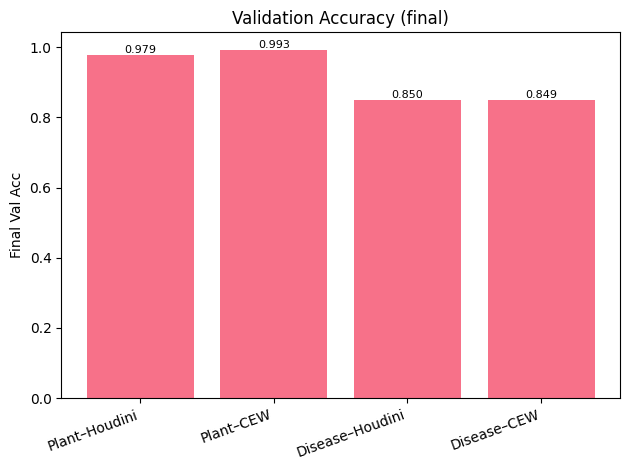

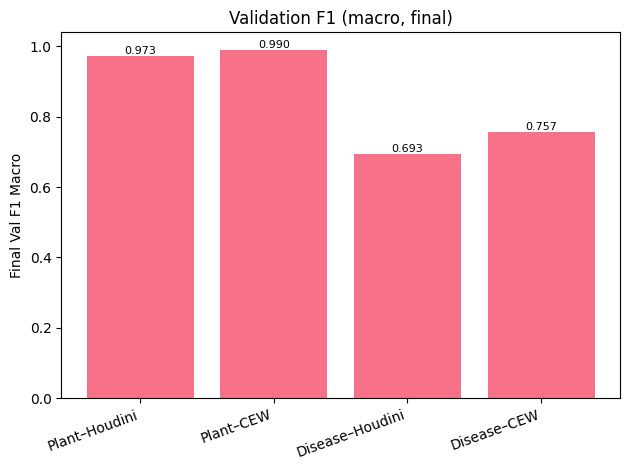

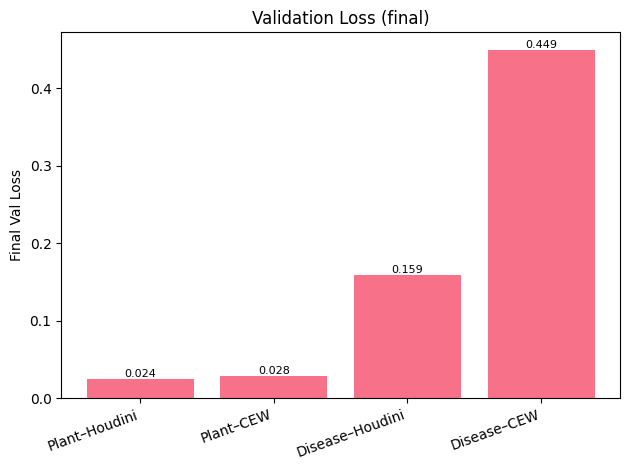

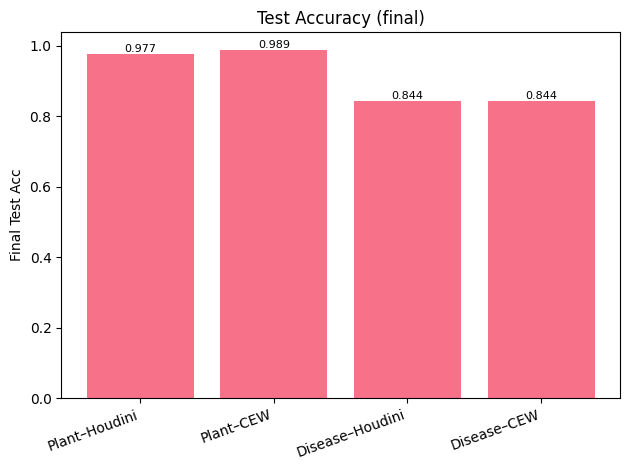

In [27]:
# ================== PLOTS ONLY (no training) ==================
# This cell expects the variables `res_plant` and `res_disease` to exist in scope.
# It DOES NOT train anything — it only visualizes existing results.

import numpy as np
import matplotlib.pyplot as plt

# ---- Utilities to safely extract histories (if present) ----
def _has_history(res):
    """Return True if both modes contain 'history' with per-epoch dicts."""
    try:
        for mode in ("houdini", "cew"):
            h = res[mode].get("history", None)
            if not isinstance(h, list) or len(h) == 0:
                return False
            # Check that the first item looks like a per-epoch dict
            if not isinstance(h[0], dict) or "epoch" not in h[0]:
                return False
        return True
    except Exception:
        return False

def _series_from(res, label_prefix: str):
    """
    Convert results[mode]['history'] into a dict of metric-> {label: (epochs, values)}.
    Expected metric keys in history: 'train_acc','train_loss','val_acc','val_f1m','val_loss'
    """
    out = {}
    for mode, nice in (("houdini", f"{label_prefix}–Houdini"),
                       ("cew",     f"{label_prefix}–CEW")):
        hist = res[mode]["history"]
        epochs = [d.get("epoch", i+1) for i,d in enumerate(hist)]
        for key_src, key_dst in (
            ("train_acc", "train_acc"),
            ("train_loss","train_loss"),
            ("val_acc",   "val_acc"),
            ("val_f1m",   "val_f1m"),
            ("val_loss",  "val_loss"),
        ):
            vals = [d[key_src] for d in hist if key_src in d]
            if len(vals) == len(epochs):
                out.setdefault(key_dst, {})
                out[key_dst][nice] = (epochs, vals)
    return out

def _plot_lines(metric_title: str, key: str, plant_series: dict, disease_series: dict):
    """Draw a line plot with 4 lines: Plant–Houdini, Plant–CEW, Disease–Houdini, Disease–CEW."""
    plt.figure()
    plotted = 0
    for label in ("Plant–Houdini","Plant–CEW","Disease–Houdini","Disease–CEW"):
        src = plant_series if label.startswith("Plant") else disease_series
        if key in src and label in src[key]:
            xs, ys = src[key][label]
            plt.plot(xs, ys, marker='o', label=label)
            plotted += 1
    plt.xlabel("Epoch")
    plt.ylabel(metric_title.split()[-1] if "Loss" not in metric_title else "Loss")
    plt.title(metric_title)
    plt.grid(True, alpha=0.3)
    if plotted:
        plt.legend()
    else:
        plt.text(0.5, 0.5, "No per-epoch history found", ha='center', va='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.show()

# ---- Fallback: bar charts from summaries (no history available) ----
def _bar_from_summaries(res_plant, res_disease, title: str, extract_key: str):
    """
    Make a 4-bar comparison (Plant–Houdini, Plant–CEW, Disease–Houdini, Disease–CEW)
    using values from results[mode]['summary'][extract_key].
    """
    labels = ["Plant–Houdini","Plant–CEW","Disease–Houdini","Disease–CEW"]
    values = []
    for res in (res_plant, res_plant, res_disease, res_disease):
        mode = "houdini" if len(values) % 2 == 0 else "cew"
        val = float(res[mode]["summary"].get(extract_key, np.nan))
        values.append(val)

    x = np.arange(len(labels))
    plt.figure()
    plt.bar(x, values)
    plt.xticks(x, labels, rotation=20, ha='right')
    plt.title(title)
    plt.ylabel(extract_key.replace("_", " ").title())
    for xi, v in zip(x, values):
        plt.text(xi, v, f"{v:.3f}" if np.isfinite(v) else "NA", ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

# ---- Decide which path to take (with or without history) ----
plant_has_hist   = _has_history(res_plant)
disease_has_hist = _has_history(res_disease)
both_have_hist   = plant_has_hist and disease_has_hist

if both_have_hist:
    # ------------- Line plots: 4 charts × 4 lines -------------
    plant_series   = _series_from(res_plant,   "Plant")
    disease_series = _series_from(res_disease, "Disease")

    # 1) Train Accuracy
    _plot_lines("Train Accuracy", "train_acc", plant_series, disease_series)
    # 2) Train Loss
    _plot_lines("Train Loss", "train_loss", plant_series, disease_series)
    # 3) Validation Accuracy
    _plot_lines("Validation Accuracy", "val_acc", plant_series, disease_series)
    # 4) Validation F1 (macro)
    _plot_lines("Validation F1 (macro)", "val_f1m", plant_series, disease_series)

else:
    # ------------- Fallback (no history): bar comparisons by summaries -------------
    # We can't reconstruct per-epoch curves. Show final comparisons instead.
    print("[info] No per-epoch history found in results. Showing final-summary comparisons only.")
    # 1) Validation Accuracy
    _bar_from_summaries(res_plant, res_disease, "Validation Accuracy (final)", "final_val_acc")
    # 2) Validation F1 (macro)
    _bar_from_summaries(res_plant, res_disease, "Validation F1 (macro, final)", "final_val_f1_macro")
    # 3) Validation Loss
    _bar_from_summaries(res_plant, res_disease, "Validation Loss (final)", "final_val_loss")
    # 4) Test Accuracy (if NaN for some mode, it'll show NA)
    _bar_from_summaries(res_plant, res_disease, "Test Accuracy (final)", "final_test_acc")


Plant recognition
(This happened because plant classification in our dataset is an easier task.)
The model shows very high accuracy on both training and validation with both loss functions. That is a good sign that we don’t have overfitting (we also verified that there is no data leakage). The loss is very low, which means the model detects patterns well.

The F1 score is close to 1, which shows we have a very good balance between precision and recall. This means the model works well with both rare and common classes. In the case of CrossEntropyLoss + class_weights, our class_weights were sufficient to fix the imbalance that we observed in Random Forest and Logistic Regression.

Disease recognition
All results are lower and worse, but still not bad with both models. Houdini achieved a better loss, but CE+W gave a better F1 score.

## Random Forest and Logistic Regression

We diside to use first off all "classical" model to compare with NW models like CNN for learning resons



> Embeding by Histogram of oriented gradients(by HOG we create tipe of map with gradient directions thet distrebiut by colors and britnes chenging give direction for each pixel itch pixel), also we use heare PCA for redusing dimantion. And HSV its clor scheme(Hue -color, Saturation, Value- britness)





> Also we use F1 score metric: 2*(Precision*Recall)/(Precision+Recall)
Precision and Recall we got from confusion matrix
Precision is TP/(TP+FP). Its mean corecct positive prediction divide all positive predicton, its mean from all positive prediction how many is realy positive. Show accurascy of prediction.
Recall is TP/(TP+FN). Its mean correct positive prediction divede all positive cases its mean from all positive cases, how many we successfully found. Show sensitivity of prediction.
F1 overall is quality of positive class classification.
F1 macro = is F1 score mean for all classes (same waite for all classes)
F1-weighted = weighted averaging for all classes (weight of each class is proportional to the number of examples in that class)


In [28]:
# === Slim HOG+PCA baseline (end-to-end, robust to (plant,disease) dual labels) ===
# All comments are in English, per your request.

import numpy as np, random, math, warnings
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.exceptions import ConvergenceWarning

# Optional frameworks (the code works even if they're missing)
try:
    import torch
except Exception:
    torch = None
try:
    import tensorflow as tf
except Exception:
    tf = None

# ----------------------------
# Config
# ----------------------------
TRAIN_FRACTION     = 0.20         # fraction of train_ds to subsample for PCA/train
RANDOM_SEED        = 42
N_COMPONENTS       = 156
USE_RANDOM_FOREST  = True

HOG_PARAMS = dict(
    orientations=9,
    pixels_per_cell=(16, 16),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    feature_vector=True
)

rng = np.random.RandomState(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch is not None:
    try: torch.manual_seed(RANDOM_SEED)
    except: pass

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Optional: define class_weights externally as a dict {class_id: weight} or None.
# Example:
# class_weights = {0: 1.0, 1: 2.0, 2: 1.3}
# If not defined, it will be ignored.
if 'class_weights' not in globals():
    class_weights = None


# ----------------------------
# Minimal helpers (framework-agnostic)
# ----------------------------
def _to_numpy(x):
    """Convert torch/tf/PIL/array-like to numpy array."""
    if torch is not None and isinstance(x, getattr(torch, "Tensor", ())):
        return x.detach().cpu().numpy()
    if tf is not None and isinstance(x, getattr(tf, "Tensor", ())):
        return x.numpy()
    try:
        from PIL import Image as _PILImage
        if isinstance(x, _PILImage.Image):
            return np.asarray(x)
    except Exception:
        pass
    return np.asarray(x)

def _hwc_from_any(img):
    """Ensure image shape is HWC or HW (with channel axis last)."""
    arr = _to_numpy(img)
    if arr.ndim == 2:
        return arr[..., None]
    if arr.ndim == 3:
        # Convert CHW to HWC if needed
        if arr.shape[0] in (1,3) and arr.shape[0] < arr.shape[-1]:
            return np.transpose(arr, (1,2,0))  # (C,H,W)->(H,W,C)
        return arr
    raise ValueError(f"Unsupported image shape: {arr.shape}")

def batch_hog(images):
    """Compute HOG features for a batch of images (HWC or HW)."""
    arr = _to_numpy(images)
    if arr.ndim == 2:
        arr = arr[None, ..., None]  # -> (1,H,W,1)
    elif arr.ndim == 3:
        arr = arr[None, ...]        # -> (1,H,W,C)
    elif arr.ndim != 4:
        raise ValueError(f"Expected 2D/3D/4D, got {arr.shape}")

    feats = []
    for i in range(arr.shape[0]):
        img = arr[i]
        if img.ndim == 3 and img.shape[-1] > 1:
            gray = np.mean(img.astype(np.float64), axis=-1)
        elif img.ndim == 3:
            gray = img[..., 0].astype(np.float64)
        else:
            gray = img.astype(np.float64)
        feats.append(feature.hog(gray, **HOG_PARAMS).astype(np.float32))
    return np.asarray(feats, dtype=np.float32)

def _is_indexable_dataset(ds):
    """Return True if ds supports __len__ and __getitem__."""
    return hasattr(ds, '__len__') and hasattr(ds, '__getitem__')

def _unwrap_example(example):
    """Extract (image, label) from common dataset formats."""
    if isinstance(example, (tuple, list)) and len(example) >= 2:
        return example[0], example[1]
    if isinstance(example, dict):
        for ki in ('image','img','x','features'):
            for kl in ('label','y','target','labels','targets'):
                if ki in example and kl in example:
                    return example[ki], example[kl]
    raise ValueError("Provide (image,label) or dict with image/label.")

def _split_dataset(ds, val_frac=0.15, test_frac=0.15, seed=RANDOM_SEED):
    """Split indexable dataset into (train,val,test) subsets."""
    if not _is_indexable_dataset(ds):
        raise ValueError("Need an indexable dataset (has __len__ and __getitem__). "
                         "If you have DataLoaders or tf.data, pass val/test explicitly.")
    n = len(ds)
    idx = np.arange(n)
    local_rng = np.random.RandomState(seed)
    local_rng.shuffle(idx)
    n_test = int(round(n * test_frac))
    n_val  = int(round(n * val_frac))
    test_idx = idx[:n_test]
    val_idx  = idx[n_test:n_test+n_val]
    train_idx = idx[n_test+n_val:]

    # Try torch Subset; else use a lightweight fallback
    try:
        import torch.utils.data as _tud
        return (_tud.Subset(ds, train_idx), _tud.Subset(ds, val_idx), _tud.Subset(ds, test_idx))
    except Exception:
        class _Subset:
            def __init__(self, base, indices): self.base, self.indices = base, list(indices)
            def __len__(self): return len(self.indices)
            def __getitem__(self, i): return self.base[self.indices[i]]
        base = ds
        return (_Subset(base, train_idx), _Subset(base, val_idx), _Subset(base, test_idx))

def _select_label(lab, label_mode):
    """
    Return a single integer label from many possible shapes:
      - scalar
      - 1D vector with >=2 elements (index 0=plant, 1=disease)
      - dict {'plant':..., 'disease':...}
      - tuple/list of two scalars (plant, disease)
    """
    # tuple/list of two scalars
    if isinstance(lab, (tuple, list)) and len(lab) >= 2 and not hasattr(lab[0], "__len__"):
        return int(lab[0] if label_mode == 'plant' else lab[1])

    if isinstance(lab, dict):
        key = 'plant' if label_mode == 'plant' else 'disease'
        return int(_to_numpy(lab[key]))

    arr = _to_numpy(lab)
    if arr.ndim == 0:
        return int(arr)
    if arr.ndim == 1 and arr.size >= 2:
        idx = 0 if label_mode == 'plant' else 1
        return int(arr[idx])
    return int(arr.reshape(()))


def _labels_from_any(yb, label_mode):
    """
    Convert batched labels of many shapes to a 1D numpy int64 vector of length B.
    Supported inputs (batched):
      - yb shape (B,) : already single task
      - yb shape (B,2) : [:,0]=plant, [:,1]=disease
      - tuple/list (plant_batch, disease_batch), each shape (B,)
      - dict {'plant': batch, 'disease': batch}
    """
    # tuple/list of two batched tensors
    if isinstance(yb, (tuple, list)) and len(yb) >= 2 and hasattr(yb[0], "__len__"):
        a = _to_numpy(yb[0])
        b = _to_numpy(yb[1])
        y = a if label_mode == 'plant' else b
        return y.astype(np.int64).reshape(-1)

    if isinstance(yb, dict):
        key = 'plant' if label_mode == 'plant' else 'disease'
        y = _to_numpy(yb[key])
        return y.astype(np.int64).reshape(-1)

    arr = _to_numpy(yb)
    # (B,2) -> pick a column
    if arr.ndim == 2 and arr.shape[1] >= 2:
        idx = 0 if label_mode == 'plant' else 1
        arr = arr[:, idx]
    # (B,1) or other >1D → flatten to (B,)
    if arr.ndim > 1:
        arr = arr.reshape(-1)
    return arr.astype(np.int64)


def collect_subset_hog(ds, take_fraction, rng, label_mode="plant"):
    """
    Collect a subsample of HOG features and labels from 'ds'.
    Works with indexable datasets and iterable/batched sources (DataLoader / tf.data).
    """
    X_list, y_list = [], []

    def _push(img, y_scalar):
        feat = batch_hog(_hwc_from_any(img)[None, ...])
        X_list.append(feat)
        y_list.append(np.int64(y_scalar).reshape(-1))

    if _is_indexable_dataset(ds):
        n = len(ds)
        k = max(1, int(n * take_fraction))
        for i in rng.choice(n, size=k, replace=False):
            img, lab = _unwrap_example(ds[i])
            y_scalar = _select_label(lab, label_mode)
            _push(img, y_scalar)
    else:
        target = 5000  # soft cap to avoid scanning entire infinite streams
        collected = 0
        for ex in ds:
            try:
                xb, yb = _unwrap_example(ex)
                xb = _to_numpy(xb)
                # Normalize images to (B,H,W,C?)
                if xb.ndim == 4 and xb.shape[1] in (1, 3) and xb.shape[1] < xb.shape[-1]:
                    xb = np.transpose(xb, (0, 2, 3, 1))  # CHW -> HWC
                elif xb.ndim == 3:
                    xb = xb[None, ...]
                if xb.ndim != 4:
                    continue

                # Get a 1D label vector of length B
                yb_vec = _labels_from_any(yb, label_mode)
                B = xb.shape[0]
                if yb_vec.shape[0] != B:
                    # Skip malformed batch
                    continue

                for i in range(B):
                    if rng.rand() <= take_fraction:
                        _push(xb[i], yb_vec[i])
                        collected += 1
                        if collected >= target:
                            raise StopIteration
            except StopIteration:
                break
            except Exception:
                continue

    if not X_list:
        dummy = feature.hog(np.zeros((32,32), dtype=np.float64), **HOG_PARAMS)
        F = dummy.size
        return np.empty((0, F), np.float32), np.empty((0,), np.int64)

    X = np.concatenate(X_list, axis=0).astype(np.float32)
    y = np.concatenate(y_list, axis=0).astype(np.int64)
    return X, y


def _iter_batches(dl, label_mode="plant"):
    """
    Yield (xb, yb) as numpy arrays:
      xb -> (B,H,W,C?), yb -> (B,)
    """
    for batch in dl:
        xb, yb = _unwrap_example(batch)
        xb_np = _to_numpy(xb)
        # Normalize image layout to (B,H,W,C?)
        if xb_np.ndim == 4 and (xb_np.shape[1] in (1,3) and xb_np.shape[1] < xb_np.shape[-1]):
            xb_np = np.transpose(xb_np, (0, 2, 3, 1))
        elif xb_np.ndim == 3:
            xb_np = xb_np[None, ...]

        # Get (B,) labels robustly
        yb_np = _labels_from_any(yb, label_mode)

        # Final sanity
        if xb_np.ndim != 4 or yb_np.ndim != 1 or xb_np.shape[0] != yb_np.shape[0]:
            # Skip malformed batch
            continue

        yield xb_np, yb_np


def eval_stream(ds, pca, clf, name="split", label_mode="plant"):
    """
    Evaluate split by streaming batches: HOG -> PCA -> predict.
    Prints metrics and returns (acc, f1_macro, f1_weighted).
    """
    y_true_all, y_pred_all = [], []
    for xb, yb in _iter_batches(ds, label_mode=label_mode):
        Xb = batch_hog(xb)
        if Xb.shape[0] == 0:
            continue
        preds = clf.predict(pca.transform(Xb)).astype(np.int64)
        y_true_all.append(yb)
        y_pred_all.append(preds)

    if not y_true_all:
        print(f"[{name}] no data")
        return 0.0, 0.0, 0.0

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro',    zero_division=0)
    f1w = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"[{name}] acc={acc:.4f}  f1_macro={f1m:.4f}  f1_weighted={f1w:.4f}")
    print(classification_report(y_true, y_pred, digits=3))
    return acc, f1m, f1w

def plot_confmat(y_true, y_pred, class_names, title, normalize='true'):
    """Utility to plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6.5,6))
    disp.plot(ax=ax, cmap='Blues', colorbar=True, values_format='.2f' if normalize else 'd')
    ax.set_title(title); plt.tight_layout(); plt.show()

def plot_f1_bars(y_true, y_pred, class_names, title):
    """Per-class F1 bar plot."""
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    f1s, labels = [], []
    for i, name in enumerate(class_names):
        key = str(i)
        if key in rep:
            f1s.append(rep[key]['f1-score']); labels.append(name)
    fig, ax = plt.subplots(figsize=(10,4.2))
    ax.bar(np.arange(len(f1s)), f1s)
    ax.set_xticks(np.arange(len(f1s))); ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylim(0,1.0); ax.set_ylabel("F1"); ax.set_title(title)
    plt.tight_layout(); plt.show()


# ----------------------------
# Main runner (legacy signature)
# ----------------------------
def make_loaders(label_mode="plant", augment_train=False):
    """
    Legacy entrypoint kept for compatibility with your notebook.
    Expects the following globals to exist:
      - train_ds : training dataset or loader
      - val_ds   : validation dataset or loader (optional)
      - test_ds  : test dataset or loader (optional)

    If val_ds/test_ds are missing and train_ds is indexable, we will split it.
    """
    # Resolve datasets/loaders from globals
    if 'train_ds' not in globals():
        raise RuntimeError("Global 'train_ds' is required. Please define train_ds before calling make_loaders().")

    local_train = globals()['train_ds']
    local_val   = globals().get('val_ds', None)
    local_test  = globals().get('test_ds', None)

    # If val/test not provided: attempt to split
    if (local_val is None or local_test is None) and _is_indexable_dataset(local_train):
        local_train, local_val, local_test = _split_dataset(local_train, val_frac=0.15, test_frac=0.15, seed=RANDOM_SEED)
    elif local_val is None or local_test is None:
        raise RuntimeError("val_ds/test_ds not found. Provide them or make train_ds indexable so we can split.")

    # 1) Subsample train for HOG+PCA fit + training
    X_train_raw, y_train = collect_subset_hog(local_train, TRAIN_FRACTION, rng, label_mode=label_mode)
    if X_train_raw.shape[0] == 0:
        raise RuntimeError("No training samples collected. Ensure your train_ds yields (image,label) and that TRAIN_FRACTION is > 0.")

    # 2) PCA on train subset
    pca = PCA(n_components=N_COMPONENTS, svd_solver='randomized', random_state=RANDOM_SEED)
    X_train_pca = pca.fit_transform(X_train_raw.astype(np.float32))

    # 3) Train baseline models
    lr = LogisticRegression(
        multi_class='multinomial', solver='saga', max_iter=2000, n_jobs=-1,
        class_weight=class_weights, verbose=0
    ).fit(X_train_pca, y_train)

    rf = None
    if USE_RANDOM_FOREST:
        rf = RandomForestClassifier(
            n_estimators=400, max_depth=None, n_jobs=-1,
            class_weight=class_weights, random_state=RANDOM_SEED
        ).fit(X_train_pca, y_train)

    # 4) Evaluate
    lr_val_acc,  lr_val_f1m,  lr_val_f1w = eval_stream(local_val,  pca, lr, "VAL / LogReg",  label_mode=label_mode)
    lr_test_acc, lr_test_f1m, lr_test_f1w = eval_stream(local_test, pca, lr, "TEST / LogReg", label_mode=label_mode)

    if rf is not None:
        rf_val_acc,  rf_val_f1m,  rf_val_f1w = eval_stream(local_val,  pca, rf, "VAL / RF",  label_mode=label_mode)
        rf_test_acc, rf_test_f1m, rf_test_f1w = eval_stream(local_test, pca, rf, "TEST / RF", label_mode=label_mode)

    # You can optionally return more (e.g., pca, models) if you want.
    return lr_test_f1m, lr_test_f1w


# ============================
# Example calls (keep as-is):
# ============================
# You must already have these in your environment:
#   train_ds, val_ds, test_ds
# If you don't have val_ds/test_ds, remove them and the code will split train_ds automatically.

print("Classic_plant")
classic_plant = make_loaders(label_mode="plant")

print("Classic_disease")
classic_disease = make_loaders(label_mode="disease")


Classic_plant
[VAL / LogReg] acc=0.7452  f1_macro=0.6575  f1_weighted=0.7316
              precision    recall  f1-score   support

           0      0.828     0.767     0.796       257
           1      0.983     0.950     0.966       240
           2      0.486     0.381     0.427       226
           3      0.844     0.199     0.321       136
           4      0.742     0.739     0.740       276
           5      0.906     0.859     0.882       291
           6      0.607     0.550     0.577       191
           7      0.745     0.661     0.701       177
           8      0.667     0.529     0.590       155
           9      0.512     0.366     0.427       112
          10      0.731     0.898     0.806      1303

    accuracy                          0.745      3364
   macro avg      0.732     0.627     0.658      3364
weighted avg      0.744     0.745     0.732      3364

[TEST / LogReg] acc=0.7571  f1_macro=0.6790  f1_weighted=0.7459
              precision    recall  f1-score   

In [29]:
import inspect
print(inspect.signature(make_loaders))


(label_mode='plant', augment_train=False)


Both Classical model show bed result in both cases. In disisise clasification the do not usefull at all

##Second cheking og edgeliks by dublikates ore sami dublicater recognithion

Exact duplicates by hash (MD5/SHA1) between splits, heare we chek if we have same sort of edge leak

In [30]:
# === Duplicate image scan (MD5) adapted to your project layout ===
from pathlib import Path
import hashlib, os
from collections import defaultdict

# Reuse your ROOT and EXTS if they exist; otherwise set safe defaults
try:
    _ROOT = ROOT
except NameError:
    _ROOT = Path(".")
try:
    _EXTS = EXTS
except NameError:
    _EXTS = {'.jpg','.jpeg','.png','.bmp','.webp','.tif','.tiff'}

def file_md5(path: Path, bufsize: int = 1 << 20) -> str:
    """Compute MD5 for a file in streaming mode (1MB chunks)."""
    h = hashlib.md5()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(bufsize), b''):
            h.update(chunk)
    return h.hexdigest()

def _detect_split(path: Path) -> str | None:
    """Return 'train'/'validation'/'test' if path contains such a segment, else None."""
    parts = {p.lower() for p in path.parts}
    for s in ("train", "validation", "test"):
        if s in parts:
            return s
    return None

def _is_image(path: Path, exts: set[str]) -> bool:
    """Check by extension (case-insensitive)."""
    return path.is_file() and path.suffix.lower() in exts

def iter_image_files(root: Path, exts: set[str]) -> list[Path]:
    """Yield all image files under train/validation/test (deep)."""
    out = []
    for split in ("train", "validation", "test"):
        d = Path(root) / split
        if not d.exists():
            continue
        # Walk recursively; avoid hidden dirs for small speed-up
        for cur, dirnames, files in os.walk(d):
            # prune hidden dirs
            dirnames[:] = [nm for nm in dirnames if not nm.startswith(".")]
            for fn in files:
                if fn.startswith("."):  # skip hidden files
                    continue
                p = Path(cur) / fn
                if _is_image(p, exts):
                    out.append(p)
    return out

def scan_hashes_root(root: Path = _ROOT, exts: set[str] = _EXTS):
    """
    Scan all images under ROOT/{train,validation,test}, compute MD5, and
    return (hash_map, dup_groups, cross_split_groups).

    - hash_map: {md5: [absolute_path, ...]}
    - dup_groups: {md5: [paths...]} only hashes that appear >1 time
    - cross_split_groups: subset of dup_groups where duplicates span different splits
    """
    hash_map: dict[str, list[str]] = defaultdict(list)

    files = iter_image_files(root, exts)
    for p in files:
        try:
            md5 = file_md5(p)
            hash_map[md5].append(str(p))
        except Exception as e:
            # Skip unreadable files but keep going
            print(f"[warn] Failed {p}: {e}")

    dup_groups = {k: v for k, v in hash_map.items() if len(v) > 1}

    def _splits_for_group(paths: list[str]) -> set[str]:
        ss = set()
        for s in paths:
            sp = _detect_split(Path(s))
            if sp is not None:
                ss.add(sp)
        return ss

    cross_split_groups = {
        k: v for k, v in dup_groups.items()
        if len(_splits_for_group(v)) >= 2
    }

    # Compact summary print
    print(f"Scanned files: {len(files)}")
    print(f"Exact duplicate groups: {len(dup_groups)}")
    print(f"Cross-split duplicate groups: {len(cross_split_groups)}")

    # Optional: show a tiny preview of first few groups
    preview = 3
    if dup_groups and preview:
        print("\nSample duplicate groups (up to 3):")
        for i, (h, paths) in enumerate(list(dup_groups.items())[:preview], 1):
            print(f"[{i}] md5={h} ({len(paths)} files)")
            for p in paths[:4]:
                print("   ", p)
            if len(paths) > 4:
                print("    ...")

    return hash_map, dup_groups, cross_split_groups

# --- Usage example (keeps your variables) ---
hmap, dups, cross = scan_hashes_root(ROOT)
print("Exact dup groups:", len(dups))
print("Cross-split dup groups:", len(cross))


Scanned files: 33826
Exact duplicate groups: 0
Cross-split duplicate groups: 0
Exact dup groups: 0
Cross-split dup groups: 0




> Near-duplicates (perceptual hash, pHash/aHash/dHash)
This helps catch crops, resizes, and minor changes.



In [31]:
# === Perceptual near-duplicate scan (pHash) for your project layout ===
# - Uses existing ROOT/EXTS if present
# - Indexes images under ROOT/{train,validation,test}
# - Computes perceptual hash (pHash) and finds cross-split near-duplicates by Hamming distance

from pathlib import Path
import os
from typing import Iterable, Tuple, List
from PIL import Image
import imagehash

# Reuse your ROOT and EXTS if available; otherwise set safe defaults
try:
    _ROOT = ROOT
except NameError:
    _ROOT = Path(".")
try:
    _EXTS = EXTS
except NameError:
    _EXTS = {'.jpg','.jpeg','.png','.bmp','.webp','.tif','.tiff'}

# ----------------- helpers -----------------
def _is_image(path: Path, exts: set) -> bool:
    """Basic extension check (case-insensitive)."""
    return path.is_file() and path.suffix.lower() in exts

def _detect_split(path: Path) -> str | None:
    """Return the split name ('train'|'validation'|'test') if present in the path parts."""
    parts = [p.lower() for p in path.parts]
    for s in ("train","validation","test"):
        if s in parts:
            return s
    return None

def _iter_image_files(root: Path, splits: Iterable[str] = ("train","validation","test"),
                      exts: set = _EXTS) -> List[Path]:
    """Yield all image files from selected splits recursively."""
    out = []
    for split in splits:
        d = Path(root) / split
        if not d.exists():
            continue
        for cur, dirnames, files in os.walk(d):
            # prune hidden dirs
            dirnames[:] = [nm for nm in dirnames if not nm.startswith(".")]
            for fn in files:
                if fn.startswith("."):
                    continue
                p = Path(cur) / fn
                if _is_image(p, exts):
                    out.append(p)
    return out

# ----------------- indexing (pHash) -----------------
def phash_index(root: Path,
                splits: Iterable[str] = ("train","validation","test"),
                hash_size: int = 16) -> List[Tuple[str, str, imagehash.ImageHash]]:
    """
    Build an index of (split, path_str, phash).
    - hash_size=16 → 16x16 DCT (larger → more precise, slightly slower)
    """
    files = _iter_image_files(root, splits=splits, exts=_EXTS)
    idx: List[Tuple[str, str, imagehash.ImageHash]] = []
    for p in files:
        split = _detect_split(p)
        if split is None:
            continue
        try:
            with Image.open(p) as im:
                # Convert to RGB to normalize mode differences
                h = imagehash.phash(im.convert("RGB"), hash_size=hash_size)
            idx.append((split, str(p), h))
        except Exception as e:
            # Keep going on errors (corrupted/unreadable files, etc.)
            print(f"[warn] skip {p}: {e}")
            continue
    return idx

# ----------------- near-duplicate detection -----------------
def near_dups(idx: List[Tuple[str,str,imagehash.ImageHash]],
              max_dist: int = 6,
              cross_split_only: bool = True,
              prefix_bucket: int = 4) -> List[Tuple[str, str, int]]:
    """
    Find perceptual near-duplicate pairs:
    - max_dist: maximum Hamming distance between hashes to consider as near-duplicate
    - cross_split_only: if True, keep only pairs that span different splits
    - prefix_bucket: compare only items that share the same first N hex chars (speed-up)
    Returns list of (path_i, path_j, distance).
    """
    # Bucket by first N hex chars to cut down comparisons
    buckets: dict[str, list[Tuple[str,str,imagehash.ImageHash]]] = {}
    for split, path, h in idx:
        key = str(h)[:prefix_bucket] if prefix_bucket > 0 else str(h)
        buckets.setdefault(key, []).append((split, path, h))

    pairs: List[Tuple[str, str, int]] = []
    for key, items in buckets.items():
        n = len(items)
        if n < 2:
            continue
        # O(n^2) inside each small bucket
        for i in range(n):
            si, pi, hi = items[i]
            for j in range(i+1, n):
                sj, pj, hj = items[j]
                d = int(hi - hj)  # Hamming distance for imagehash.ImageHash
                if d <= max_dist:
                    if not cross_split_only or (si != sj):
                        pairs.append((pi, pj, d))
    return pairs

# ----------------- run -----------------
# Usage:
#   idx = phash_index(_ROOT, splits=("train","validation","test"), hash_size=16)
#   pairs = near_dups(idx, max_dist=6, cross_split_only=True, prefix_bucket=4)
#   print("Cross-split near-duplicate pairs:", len(pairs))
#   for a,b,d in pairs[:10]:
#       print(d, "\n ", a, "\n ", b)

idx = phash_index(_ROOT, splits=("train","validation","test"), hash_size=16)
pairs = near_dups(idx, max_dist=6, cross_split_only=True, prefix_bucket=4)

print("Cross-split near-duplicate pairs:", len(pairs))
for a, b, d in pairs[:10]:
    print(d, "\n ", a, "\n ", b)


Cross-split near-duplicate pairs: 0


##Models Compitishion

Now we'll check other models, to compare our own with.

In [ ]:
# ==========================================================
# Fair sweep on 20% TRAIN subset (no disk saves)
# - Works with label_mode in {"plant","disease"}
# - Plug-in metrics (your own metrics can be passed in)
# - Supports your class weight dicts {class_name: weight}
# - Uses prepared splits at ROOT/train|validation|test
# - TF-like per-image standardization (on 0..255 scale)
# - Auto image size per model (fixes DeiT 224 vs 256)
# - Colab-safe DataLoader (num_workers=0) to avoid MP assertion
# ==========================================================

# If needed in your environment:
# !pip -q install timm

from pathlib import Path
import os, gc, time, math, random, numpy as np, warnings
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import timm

# -----------------------
# Config
# -----------------------
ROOT             = Path(data_path) / "image data" if (Path(data_path) / "image data").exists() else Path(data_path)
SUBSAMPLE_FRAC   = 0.10         # exact 20% of TRAIN
EPOCHS_SWEEP     = 4
BATCH_SIZE       = 64
NUM_WORKERS_SAFE = 0            # avoids Colab "can only test a child process" assertion
PIN_MEM          = (torch.cuda.is_available())
LR               = 3e-4
WEIGHT_DECAY     = 1e-4
RANDOM_SEED      = 42

# Strategy for CE weights when houdini_loss is NOT provided:
USE_TRAIN_BALANCED_WEIGHTS = False  # if False -> prefer your dict weights when provided

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
g = torch.Generator().manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED); torch.manual_seed(RANDOM_SEED)

print("Device:", device)
print("Root:", str(ROOT))

# -----------------------
# TF-like per-image standardization (on 0..255 scale)
# -----------------------
def per_image_standardization_torch(x: torch.Tensor) -> torch.Tensor:
    """
    x: float tensor in [0,1], shape [3,H,W].
    Emulates tf.image.per_image_standardization(image * 255.0):
      - mean/std over ALL pixels and channels on 0..255 scale
      - adjusted_std = max(std, 1/sqrt(N))
      - output = (x*255 - mean) / adjusted_std
    """
    x255 = x * 255.0
    mean = x255.mean()
    var  = x255.var(unbiased=False)
    std  = torch.sqrt(var + 1e-12)
    adjusted_std = torch.maximum(std, torch.tensor(1.0 / math.sqrt(x255.numel()), device=x.device, dtype=x.dtype))
    return (x255 - mean) / adjusted_std

class PerImageStandardize(object):
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return per_image_standardization_torch(x)

def build_transforms(img_size: int):
    """Build train/eval transforms for a given model's required img_size."""
    train_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.2,0.2,0.2,0.03),
        transforms.ToTensor(),
        PerImageStandardize(),  # TF-like standardization
    ])
    eval_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        PerImageStandardize(),
    ])
    return train_tfms, eval_tfms

# -----------------------
# Dataset that supports label_mode={"plant","disease"}
# Expected tree: ROOT/split/PLANT/DISEASE/*.jpg
# -----------------------
EXTS = {'.jpg','.jpeg','.png','.bmp','.webp','.tif','.tiff'}

def collect_split(split, label_mode="plant"):
    """
    Build (paths, labels_str) for split.
    label_mode='plant'   -> label = plant_dir.name
    label_mode='disease' -> label = disease_dir.name (merged across plants)
    """
    assert label_mode in {"plant","disease"}
    paths, labels = [], []
    split_dir = ROOT / split
    if not split_dir.exists():
        return paths, labels
    for plant_dir in sorted(p for p in split_dir.iterdir() if p.is_dir()):
        plant = plant_dir.name
        for disease_dir in sorted(p for p in plant_dir.iterdir() if p.is_dir()):
            disease = disease_dir.name
            for f in disease_dir.rglob("*"):
                if f.is_file() and f.suffix.lower() in EXTS:
                    paths.append(str(f))
                    labels.append(plant if label_mode=="plant" else disease)
    return paths, labels

class PathsDataset(Dataset):
    """Lightweight dataset built from arrays of paths and numeric labels."""
    def __init__(self, paths_np, labels_np, transform):
        self.paths_np = paths_np
        self.labels_np = labels_np
        self.transform = transform
    def __len__(self): return len(self.paths_np)
    def __getitem__(self,i):
        p = self.paths_np[i]; y = int(self.labels_np[i])
        img = Image.open(p).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        # transform ends with ToTensor + PerImageStandardize, so 'img' is torch.Tensor
        return img, y

# -----------------------
# Build base label space and stratified subset for TRAIN
# -----------------------
def make_base_and_subset(label_mode="plant"):
    """Collect splits, build class->index mapping, and create 20% stratified subset indices."""
    tr_p, tr_l_s = collect_split("train", label_mode)
    va_p, va_l_s = collect_split("validation", label_mode)
    te_p, te_l_s = collect_split("test", label_mode)

    classes = sorted(set(tr_l_s + va_l_s + te_l_s))
    lbl2idx = {c:i for i,c in enumerate(classes)}

    tr_y = np.array([lbl2idx[s] for s in tr_l_s], dtype=np.int64)
    va_y = np.array([lbl2idx[s] for s in va_l_s], dtype=np.int64)
    te_y = np.array([lbl2idx[s] for s in te_l_s], dtype=np.int64)

    tr_p = np.array(tr_p); va_p = np.array(va_p); te_p = np.array(te_p)

    # build stratified 20% from TRAIN ONLY
    by_c = {}
    for i,t in enumerate(tr_y): by_c.setdefault(int(t), []).append(i)
    rng = np.random.default_rng(RANDOM_SEED)
    subset_idx = []
    for idxs in by_c.values():
        k = max(1, int(round(len(idxs)*SUBSAMPLE_FRAC)))
        subset_idx.extend(rng.choice(idxs, size=k, replace=False).tolist())
    rng.shuffle(subset_idx)

    base = dict(
        classes=classes, C=len(classes),
        train_paths=tr_p, train_targets=tr_y,
        val_paths=va_p,   val_targets=va_y,
        test_paths=te_p,  test_targets=te_y,
        train_subset_idx=subset_idx
    )
    return base

# -----------------------
# Rebuild DataLoaders for a given img_size (per model)
# -----------------------
def build_dls_for_imgsize(img_size, base):
    tr_tfms, ev_tfms = build_transforms(img_size)

    train_full = PathsDataset(base['train_paths'], base['train_targets'], transform=tr_tfms)
    val_full   = PathsDataset(base['val_paths'],   base['val_targets'],   transform=ev_tfms)
    test_full  = PathsDataset(base['test_paths'],  base['test_targets'],  transform=ev_tfms)

    train_ds = Subset(train_full, base['train_subset_idx'])
    val_ds   = val_full
    test_ds  = test_full

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS_SAFE, pin_memory=PIN_MEM, generator=g)
    val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS_SAFE, pin_memory=PIN_MEM)
    test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS_SAFE, pin_memory=PIN_MEM)
    return train_dl, val_dl, test_dl

def infer_img_size_from_model(m):
    """Read target input size from timm model default_cfg; fallback to 224."""
    cfg = getattr(m, 'default_cfg', None) or {}
    inp = cfg.get('input_size', (3, 224, 224))
    return int(inp[1])

# -----------------------
# Weights alignment and criterion builder
# -----------------------
def align_weights_from_dict(classes, weights_dict:dict|None):
    """
    Align a user-provided dict {class_name: weight} to a torch tensor in `classes` order.
    Warn if there are missing or extra keys. If missing, fallback to 1.0.
    """
    if not weights_dict:
        return None
    miss = [c for c in classes if c not in weights_dict]
    extra = [k for k in weights_dict.keys() if k not in classes]
    if miss:
        warnings.warn(f"[class weights] missing classes: {miss}; using 1.0 for them")
    if extra:
        warnings.warn(f"[class weights] extra keys not in classes: {extra} (ignored)")
    arr = np.array([weights_dict.get(c, 1.0) for c in classes], dtype=np.float32)
    return torch.tensor(arr, device=device)

def build_ce_balanced_weights_from_subset(targets_full, subset_idx, C):
    """Compute classic balanced weights from TRAIN subset labels."""
    sub_targets = targets_full[subset_idx]
    counts = np.bincount(sub_targets, minlength=C).astype(np.float32)
    class_w = (counts.sum() / (C * np.clip(counts, 1, None))).astype(np.float32)
    return torch.tensor(class_w, device=device)

# -----------------------
# Eval helper: returns (loss, acc, f1_macro) + y_true/y_pred/y_proba
# -----------------------
@torch.no_grad()
def eval_split(model, dl, criterion):
    model.eval(); y_true = []; y_pred = []; y_prob = []; loss_sum = 0.0; n_tot = 0
    for x,y in dl:
        x,y = x.to(device), y.to(device)
        logits = model(x); loss = criterion(logits, y)
        loss_sum += loss.item()*y.size(0); n_tot += y.size(0)
        y_true.extend(y.cpu().numpy().tolist())
        p = logits.argmax(1)
        y_pred.extend(p.cpu().numpy().tolist())
        y_prob.append(torch.softmax(logits, dim=1).cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)
    y_prob = np.concatenate(y_prob, axis=0) if len(y_prob) else None
    return (loss_sum/n_tot if n_tot>0 else 0.0), acc, f1m, np.array(y_true), np.array(y_pred), y_prob

# -----------------------
# Train a timm model for the sweep (per-model img size)
# -----------------------
def train_model(name, base, classes, criterion_builder, epochs=EPOCHS_SWEEP, lr=LR, wd=WEIGHT_DECAY):
    # free memory between models
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    gc.collect()

    # create model first to get its suggested input size
    m = timm.create_model(name, pretrained=True, num_classes=len(classes), drop_rate=0.2).to(device)
    img_size = infer_img_size_from_model(m)

    # dataloaders for this img_size
    train_dl, val_dl, test_dl = build_dls_for_imgsize(img_size, base)

    # criterion (closure over device/weights)
    crit = criterion_builder(device)

    # optional tweak for short-run stability
    local_lr = lr
    if 'convnext_tiny' in name:
        local_lr = min(lr, 2e-4)

    opt  = torch.optim.AdamW(m.parameters(), lr=local_lr, weight_decay=wd)
    sch  = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

    best_f1 = -1.0; best_state = None
    epoch_times = []
    t0 = time.time()

    for ep in range(1, epochs+1):
        m.train()
        ep_start = time.time()
        for x,y in train_dl:
            x,y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                logits = m(x); loss = crit(logits, y)
            scaler.scale(loss).backward()
            # torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)  # uncomment if needed
            scaler.step(opt); scaler.update()
        sch.step()
        ep_secs = time.time() - ep_start
        epoch_times.append(ep_secs)

        # validation metrics
        v_loss, v_acc, v_f1, _, _, _ = eval_split(m, val_dl, crit)
        if v_f1 > best_f1:
            best_f1   = v_f1
            best_state = {k: v.detach().cpu() for k,v in m.state_dict().items()}

        print(f"[{name}] epoch {ep:02d}/{epochs} | "
              f"val acc {v_acc:.3f} f1M {v_f1:.3f} loss {v_loss:.3f} | "
              f"time {ep_secs:.1f}s (img_size={img_size})")

    total_secs = time.time() - t0

    # test with best state (in-memory only)
    if best_state is not None:
        m.load_state_dict(best_state, strict=True)

    t_loss, t_acc, t_f1, y_true, y_pred, y_proba = eval_split(m, test_dl, crit)

    params_M = sum(p.numel() for p in m.parameters())/1e6
    return {
        'name': name,
        'val_f1_best': float(best_f1),
        'test_acc': float(t_acc),
        'test_f1': float(t_f1),
        'params_M': float(params_M),
        'total_secs': float(total_secs),
        'avg_epoch_secs': float(np.mean(epoch_times)) if epoch_times else float('nan'),
        'epoch_secs_list': [float(s) for s in epoch_times],
        'y_true': y_true.tolist(),
        'y_pred': y_pred.tolist(),
        # y_proba can be large; include if you need calibration/AUC style metrics
        # 'y_proba': y_proba.tolist() if y_proba is not None else None,
    }, (m, crit, (train_dl, val_dl, test_dl))

# -----------------------
# Random Forest baseline on pooled features (optional)
# -----------------------
def random_forest_baseline(base, classes, backbone='resnet18'):
    from sklearn.ensemble import RandomForestClassifier

    # feature extractor @224
    _, ev_tfms = build_transforms(224)
    feat_train = PathsDataset(base['train_paths'][base['train_subset_idx']], base['train_targets'][base['train_subset_idx']], transform=ev_tfms)
    feat_val   = PathsDataset(base['val_paths'],  base['val_targets'],  transform=ev_tfms)
    feat_test  = PathsDataset(base['test_paths'], base['test_targets'], transform=ev_tfms)

    dl_train = DataLoader(feat_train, batch_size=128, shuffle=False, num_workers=NUM_WORKERS_SAFE, pin_memory=PIN_MEM)
    dl_val   = DataLoader(feat_val,   batch_size=128, shuffle=False, num_workers=NUM_WORKERS_SAFE, pin_memory=PIN_MEM)
    dl_test  = DataLoader(feat_test,  batch_size=128, shuffle=False, num_workers=NUM_WORKERS_SAFE, pin_memory=PIN_MEM)

    extractor = timm.create_model(backbone, pretrained=True, num_classes=0, global_pool='avg').to(device).eval()

    def collect(dl):
        feats, ys = [], []
        with torch.no_grad():
            for x,y in dl:
                x = x.to(device)
                f = extractor(x).detach().cpu().numpy()
                feats.append(f); ys.extend(y.numpy().tolist())
        return np.concatenate(feats, axis=0), np.array(ys, dtype=np.int64)

    t0 = time.time()
    Xtr, ytr = collect(dl_train)
    Xva, yva = collect(dl_val)
    Xte, yte = collect(dl_test)

    rf = RandomForestClassifier(n_estimators=300, max_features='sqrt', n_jobs=-1, random_state=RANDOM_SEED)
    rf.fit(Xtr, ytr)
    secs = time.time() - t0

    vpred = rf.predict(Xva); tpred = rf.predict(Xte)
    vacc  = accuracy_score(yva, vpred)
    tacc  = accuracy_score(yte, tpred)
    tf1   = f1_score(yte, tpred, average='macro', zero_division=0)

    return {
        'name': f'random_forest({backbone}-feats)',
        'val_f1_best': float('nan'),
        'test_acc': float(tacc),
        'test_f1': float(tf1),
        'params_M': 0.0,
        'total_secs': float(secs),
        'avg_epoch_secs': float('nan'),
        'epoch_secs_list': [],
    }

# -----------------------
# Metrics plug-in examples
# Each fn: (y_true, y_pred, y_proba, classes) -> dict
# -----------------------
def metric_confmat(y_true, y_pred, y_proba, classes):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
    return {"confusion_matrix": cm.tolist()}

def metric_report(y_true, y_pred, y_proba, classes):
    rep = classification_report(y_true, y_pred, target_names=classes, zero_division=0, output_dict=True)
    return {"classification_report": rep}  # nested dict is OK to log

# Put your own custom metrics here (they will be called after each model test)
metrics_list = [metric_confmat]  # extend with your metrics

# -----------------------
# Criterion builder factory
# Uses your houdini_loss if present; else CrossEntropy with either your weights dict
# or balanced weights computed from the TRAIN subset (configurable).
# -----------------------
def make_criterion_builder(base, classes, class_weights_dict=None):
    aligned_user_w = align_weights_from_dict(classes, class_weights_dict) if class_weights_dict else None
    ce_balanced_w  = build_ce_balanced_weights_from_subset(base['train_targets'], base['train_subset_idx'], len(classes))

    if 'houdini_loss' in globals():
        print("Using external houdini_loss.")
        def builder(_device):
            def criterion(logits, y): return houdini_loss(logits, y)
            return criterion
        return builder
    else:
        if not USE_TRAIN_BALANCED_WEIGHTS and aligned_user_w is not None:
            print("Using CrossEntropyLoss with YOUR aligned class weights.")
            def builder(_device):
                return nn.CrossEntropyLoss(weight=aligned_user_w)
            return builder
        else:
            print("Using CrossEntropyLoss with balanced class weights (computed on TRAIN subset).")
            def builder(_device):
                return nn.CrossEntropyLoss(weight=ce_balanced_w)
            return builder

# -----------------------
# Sweep runner (per label_mode)
# -----------------------
def run_sweep(label_mode="plant", class_weights_dict=None, candidates=None, epochs=EPOCHS_SWEEP, add_rf=True):
    base = make_base_and_subset(label_mode=label_mode)
    classes = base['classes']
    print(f"Label mode: {label_mode} | Classes: {len(classes)} "
          f"| Train={len(base['train_paths'])} | Val={len(base['val_paths'])} | Test={len(base['test_paths'])}")
    print(f"Train subset: {len(base['train_subset_idx'])} ({SUBSAMPLE_FRAC*100:.0f}% of TRAIN)")

    if candidates is None:
        candidates = [
            'resnet18',
            'resnet50',
            'efficientnet_b2',
            'convnext_tiny',
            'deit_small_patch16_224',
        ]

    criterion_builder = make_criterion_builder(base, classes, class_weights_dict=class_weights_dict)

    results = []
    models_cache = {}

    for name in candidates:
        try:
            r, pack = train_model(name, base, classes, criterion_builder, epochs=epochs, lr=LR, wd=WEIGHT_DECAY)
            results.append(r)
            models_cache[name] = pack  # (model, crit, (train_dl,val_dl,test_dl))
            print(f"{name:24s} best_val_f1={r['val_f1_best']:.3f} test_acc={r['test_acc']:.3f} "
                  f"f1M={r['test_f1']:.3f} params={r['params_M']:.1f} "
                  f"time={r['total_secs']:.1f}s (avg/epoch={r['avg_epoch_secs']:.1f}s)")
        except Exception as e:
            print(f"[ERROR] {name}: {e}")

    if add_rf:
        try:
            rf_res = random_forest_baseline(base, classes, backbone='resnet18')
            results.append(rf_res)
            print(f"{rf_res['name']:24s} test_acc={rf_res['test_acc']:.3f} "
                  f"f1M={rf_res['test_f1']:.3f} time={rf_res['total_secs']:.1f}s")
        except Exception as e:
            print(f"[ERROR] random_forest: {e}")

    # Sort by best validation F1; fallback to test_f1
    def sort_key(d):
        return (d.get('val_f1_best', float('-inf')), d.get('test_f1', float('-inf')))
    results = sorted(results, key=sort_key, reverse=True)

    # Run plug-in metrics on the BEST model (optional; you can loop over all if needed)
    if metrics_list and len(models_cache):
        best_name = results[0]['name']
        model, crit, (tr_dl, va_dl, te_dl) = models_cache[best_name]
        # Eval again to get arrays for metrics
        _, _, _, y_true, y_pred, y_proba = eval_split(model, te_dl, crit)
        extra = {}
        for fn in metrics_list:
            try:
                extra |= fn(y_true, y_pred, y_proba, classes)
            except Exception as e:
                warnings.warn(f"[metrics] '{getattr(fn,'__name__',str(fn))}' failed: {e}")
        results[0]['extra_metrics_test'] = extra

        # Optional: print classification report for the best model
        try:
            rep = classification_report(y_true, y_pred, target_names=classes, zero_division=0)
            print("\n[Best model test classification report]\n", rep)
        except Exception:
            pass

    sweep_out = {
        'label_mode': label_mode,
        'classes': classes,
        'subset_sizes': {
            'train_subset': len(base['train_subset_idx']),
            'val': len(base['val_paths']),
            'test': len(base['test_paths'])
        },
        'results': results
    }

    print("\nTop-5:")
    for row in results[:5]:
        print(row)
    return sweep_out

# -----------------------
# HOW TO RUN
# (Provide your dicts: class_weights_plants / class_weights_diseases)
# Each dict must map CLASS NAME (as appears in 'classes') -> weight
# -----------------------
# Example:
sweep_plants   = run_sweep(label_mode="plant",   class_weights_dict=class_weights_plants,   candidates=None, epochs=EPOCHS_SWEEP, add_rf=True)
sweep_diseases = run_sweep(label_mode="disease", class_weights_dict=class_weights_disease, candidates=None, epochs=EPOCHS_SWEEP, add_rf=True)


Device: cuda
Root: /content/leaf_disease_data/image data
Label mode: plant | Classes: 11 | Train=27045 | Val=3364 | Test=3417
Train subset: 2703 (10% of TRAIN)
Using external houdini_loss.


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

[resnet18] epoch 01/4 | val acc 0.739 f1M 0.581 loss 0.310 | time 23.5s (img_size=224)
[resnet18] epoch 02/4 | val acc 0.920 f1M 0.877 loss 0.150 | time 23.3s (img_size=224)
[resnet18] epoch 03/4 | val acc 0.952 f1M 0.923 loss 0.101 | time 23.4s (img_size=224)
[resnet18] epoch 04/4 | val acc 0.967 f1M 0.948 loss 0.089 | time 23.3s (img_size=224)
resnet18                 best_val_f1=0.948 test_acc=0.965 f1M=0.946 params=11.2 time=135.5s (avg/epoch=23.4s)


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

[resnet50] epoch 01/4 | val acc 0.714 f1M 0.510 loss 0.311 | time 30.0s (img_size=224)


In [ ]:
# ===================== Sweep comparison plots (NO TRAINING) =====================
# Expects:
#   - sweep_plants   = run_sweep(... label_mode="plant" ...)
#   - sweep_diseases = run_sweep(... label_mode="disease" ...)
# Builds 4 bar charts per sweep (all models shown on each chart).

import matplotlib.pyplot as plt
import numpy as np

def _extract_metric_list(sweep_out, key, default_key=None):
    """
    Extracts (labels, values) for a metric from sweep_out['results'].
    If 'key' does not exist in rows and default_key is provided, use it instead.
    """
    rows = sweep_out.get('results', [])
    names = [r.get('name', f'model_{i}') for i, r in enumerate(rows)]
    # If metric not present, try default_key
    if rows and key not in rows[0] and default_key is not None:
        key = default_key
    vals = [float(r.get(key, np.nan)) for r in rows]
    return names, vals, key

def _bar_plot(ax, names, vals, title, ylabel):
    x = np.arange(len(names))
    ax.bar(x, vals)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=20, ha='right')
    # Annotate bars
    for xi, v in zip(x, vals):
        label = "NA" if not np.isfinite(v) else f"{v:.3f}"
        ax.text(xi, v if np.isfinite(v) else 0.0, label, ha='center', va='bottom', fontsize=8)
    ax.grid(axis='y', alpha=0.25)

def plot_sweep_four(sweep_out, title_prefix=""):
    """
    Makes 4 bar charts for a given sweep_out:
      1) Validation F1 (best)
      2) Validation Loss  (or Test F1 if val_loss not recorded)
      3) Test Accuracy
      4) Test F1
    Shows all models on each chart.
    """
    # 1) Validation F1 (best across epochs)
    names1, vals1, _ = _extract_metric_list(sweep_out, "val_f1_best")

    # 2) Validation Loss (fallback → test_f1)
    names2, vals2, used2 = _extract_metric_list(sweep_out, "val_loss_best", default_key="test_f1")
    title2 = "Validation Loss" if used2 == "val_loss_best" else "Test F1 (fallback)"

    # 3) Test Accuracy
    names3, vals3, _ = _extract_metric_list(sweep_out, "test_acc")

    # 4) Test F1
    names4, vals4, _ = _extract_metric_list(sweep_out, "test_f1")

    # Ensure consistent model ordering across plots (use order of results)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    plt.suptitle(f"{title_prefix} — Model Comparison", y=1.02, fontsize=14)

    _bar_plot(axes[0,0], names1, vals1, "Validation F1 (best)", "F1")
    _bar_plot(axes[0,1], names2, vals2, title2,            "Loss" if used2 == "val_loss_best" else "F1")
    _bar_plot(axes[1,0], names3, vals3, "Test Accuracy",       "Accuracy")
    _bar_plot(axes[1,1], names4, vals4, "Test F1 (macro)",     "F1")

    plt.tight_layout()
    plt.show()

# --------- Run for both sweeps (each will show 4 charts with all 5 models) ----------
plot_sweep_four(sweep_plants,   title_prefix="PLANT")
plot_sweep_four(sweep_diseases, title_prefix="DISEASE")


Plants desease
most qualiti models heare is deit_small_patch16_224: F1≈0.994, acc≈0.996 and resnet50: F1≈0.994, acc≈0.995
best balansed between qality and namber of parrams is efficientnet_b2: F1=0.992 прandи 7.7M params
resnet18 that we used is fusters and with well qualiti and not to hight number of parms: F1+0.986 and 11M parms

#Test

After model comnpitishion we diside to chose DeiT becouse that model the best result with the best condiant indicators. We also diside to use to loss function tigesser becose Houdini had much better loss that show better mattematishional result bat CE+Weights show better F1(F1=0.867 vs F1=0.844) that more usfull in real cases.

How we tooned model:
1. Learning Rate Schedulers:
WarmRestarts:
 First of all we disede to stabalize ower few firs epoch becouse of that we diside increase learning rate for firs part of cicle. (It will help to model exit to local minimum and it vill hel to find better one)
 Seconde
2. We also increase namber of Epoch and patience namber(Give more time for improovment)
3. Gradient Clipping: limits the norm of gradients it help Predotvrashchayet gradient explosion prevents gradient explosion (When gradint of lost function start to grow exponentionally)
4. DropPath turn of some neyronse its can help prevent overfit becouse the model less depent of specidic layers   

In [ ]:
# === DeiT multi-task (plant, disease) with mixed loss (0.3*Houdini + 0.7*CEweights) ===
# - Data tree: ROOT/split/PLANT/DISEASE/*.jpg
# - Two heads: plant_head, disease_head
# - Proper regularization: drop_path (DeiT), label smoothing, dropout in heads, grad clipping
# - Per-image standardization (TF-like), no ImageNet normalize, as in your pipeline

import os, time, math, warnings, numpy as np
from pathlib import Path
from typing import Optional, Dict, List, Tuple

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image

from sklearn.metrics import f1_score, classification_report, accuracy_score
import timm

# -----------------------
# Config
# -----------------------
ROOT             = Path(data_path) / "image data" if (Path(data_path) / "image data").exists() else Path(data_path)
MODEL_NAME       = "deit_small_mt_houdini0.3_cew0.7"
EPOCHS           = 20
PATIENCE         = 4
BATCH_SIZE       = 64
NUM_WORKERS      = 2
LR               = 3e-4
WEIGHT_DECAY     = 1e-4
LABEL_SMOOTHING  = 0.1
SUBSAMPLE_FRAC   = 0.2          # set to 0.20 for 20% of train
RANDOM_SEED      = 42
TEST_EVERY_EPOCH = True
DROPPATH_RATE    = 0.1          # stochastic depth inside DeiT
HEAD_DROPOUT     = 0.2          # dropout before linear heads
MAX_GRAD_NORM    = 1.0          # gradient clipping
IMG_SIZE         = 224          # DeiT default

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pin_mem = (device.type == 'cuda')
print("Device:", device)
print("Root:", str(ROOT))

# -----------------------
# Optional: your weights dicts (class_name -> weight)
# Fill these from your code, or leave None to auto-balance on subset:
# -----------------------
class_weights_plants   = None  # e.g., {"tomato": 0.8, "rice": 1.2, ...}
class_weights_diseases = None  # e.g., {"late blight": 1.3, ...}

# -----------------------
# TF-like per-image standardization (on 0..255 scale)
# -----------------------
def per_image_standardization_torch(x: torch.Tensor) -> torch.Tensor:
    """Standardize a single image tensor channel-wise after scaling to [0,255]."""
    x255 = x * 255.0
    mean = x255.mean()
    var  = x255.var(unbiased=False)
    std  = torch.sqrt(var + 1e-12)
    adjusted_std = torch.maximum(std, torch.tensor(1.0 / math.sqrt(x255.numel()), device=x.device, dtype=x.dtype))
    return (x255 - mean) / adjusted_std

class PerImageStandardize(object):
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return per_image_standardization_torch(x)

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2,0.03),
    transforms.ToTensor(),
    PerImageStandardize(),
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    PerImageStandardize(),
])

# -----------------------
# Build paths + multi-task labels from file tree
# -----------------------
EXTS = {'.jpg','.jpeg','.png','.bmp','.webp','.tif','.tiff'}

def collect_split_mt(split: str) -> Tuple[List[str], List[str], List[str]]:
    """
    Return (paths, plant_labels_str, disease_labels_str) for given split.
    Expect: ROOT/split/PLANT/DISEASE/*.*
    """
    split_dir = ROOT / split
    paths, plants, diseases = [], [], []
    if not split_dir.exists():
        return paths, plants, diseases
    for plant_dir in sorted(p for p in split_dir.iterdir() if p.is_dir()):
        plant = plant_dir.name
        for disease_dir in sorted(p for p in plant_dir.iterdir() if p.is_dir()):
            disease = disease_dir.name
            for f in disease_dir.rglob("*"):
                if f.is_file() and f.suffix.lower() in EXTS:
                    paths.append(str(f)); plants.append(plant); diseases.append(disease)
    return paths, plants, diseases

def build_label_spaces() -> dict:
    tr_p, tr_pl, tr_di = collect_split_mt("train")
    va_p, va_pl, va_di = collect_split_mt("validation")
    te_p, te_pl, te_di = collect_split_mt("test")

    plant_classes   = sorted(set(tr_pl + va_pl + te_pl))
    disease_classes = sorted(set(tr_di + va_di + te_di))
    p2i = {c:i for i,c in enumerate(plant_classes)}
    d2i = {c:i for i,c in enumerate(disease_classes)}

    tr_y_p = np.array([p2i[s] for s in tr_pl], dtype=np.int64)
    tr_y_d = np.array([d2i[s] for s in tr_di], dtype=np.int64)
    va_y_p = np.array([p2i[s] for s in va_pl], dtype=np.int64)
    va_y_d = np.array([d2i[s] for s in va_di], dtype=np.int64)
    te_y_p = np.array([p2i[s] for s in te_pl], dtype=np.int64)
    te_y_d = np.array([d2i[s] for s in te_di], dtype=np.int64)

    return dict(
        train_paths=np.array(tr_p),  train_plant=tr_y_p,  train_disease=tr_y_d,
        val_paths=np.array(va_p),    val_plant=va_y_p,    val_disease=va_y_d,
        test_paths=np.array(te_p),   test_plant=te_y_p,   test_disease=te_y_d,
        plant_classes=plant_classes, disease_classes=disease_classes
    )

class MTPathsDataset(Dataset):
    """Returns (image_tensor, plant_idx, disease_idx)."""
    def __init__(self, paths, y_plant, y_disease, transform):
        self.paths = paths; self.y_p = y_plant; self.y_d = y_disease
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        if self.transform is not None: img = self.transform(img)
        return img, int(self.y_p[i]), int(self.y_d[i])

base = build_label_spaces()
print(f"Plants: {len(base['plant_classes'])} | Diseases: {len(base['disease_classes'])}")
print(f"Train={len(base['train_paths'])} | Val={len(base['val_paths'])} | Test={len(base['test_paths'])}")

# -----------------------
# Subsample 20% of TRAIN if requested
# -----------------------
if SUBSAMPLE_FRAC < 1.0:
    # stratified by PLANT (could also stratify jointly; plant is fine here)
    by_c = {}
    for i,t in enumerate(base['train_plant']): by_c.setdefault(int(t), []).append(i)
    rng = np.random.default_rng(RANDOM_SEED)
    idx_sub = []
    for idxs in by_c.values():
        k = max(1, int(round(len(idxs)*SUBSAMPLE_FRAC)))
        idx_sub.extend(rng.choice(idxs, size=k, replace=False).tolist())
    rng.shuffle(idx_sub)
else:
    idx_sub = np.arange(len(base['train_paths'])).tolist()

train_ds_full = MTPathsDataset(base['train_paths'], base['train_plant'], base['train_disease'], transform=train_tfms)
val_ds        = MTPathsDataset(base['val_paths'],   base['val_plant'],   base['val_disease'],   transform=eval_tfms)
test_ds       = MTPathsDataset(base['test_paths'],  base['test_plant'],  base['test_disease'],  transform=eval_tfms)

train_ds = Subset(train_ds_full, idx_sub)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=pin_mem)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_mem)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_mem)

print(f"Train subset: {len(train_ds)} (of {len(train_ds_full)})")

# -----------------------
# Align weights helpers
# -----------------------
def align_weights_from_dict(classes: List[str], weights_dict: Optional[Dict[str, float]]):
    """Map user {class_name: weight} -> tensor aligned to classes order."""
    if not weights_dict:
        return None
    miss = [c for c in classes if c not in weights_dict]
    extra = [k for k in weights_dict if k not in classes]
    if miss:  warnings.warn(f"[class weights] missing: {miss}; using 1.0")
    if extra: warnings.warn(f"[class weights] extra keys ignored: {extra}")
    arr = np.array([weights_dict.get(c, 1.0) for c in classes], dtype=np.float32)
    return torch.tensor(arr, device=device)

def balanced_weights_from_subset(targets: np.ndarray, num_classes: int) -> torch.Tensor:
    """Classic balanced weights computed from subset labels."""
    counts = np.bincount(targets, minlength=num_classes).astype(np.float32)
    w = (counts.sum() / (num_classes * np.clip(counts, 1, None))).astype(np.float32)
    return torch.tensor(w, device=device)

# Build per-head CE weights
sub_idx_np = np.array(idx_sub, dtype=np.int64)
train_pl_subset = base['train_plant'][sub_idx_np]
train_di_subset = base['train_disease'][sub_idx_np]

w_pl_user = align_weights_from_dict(base['plant_classes'],   class_weights_plants)
w_di_user = align_weights_from_dict(base['disease_classes'], class_weights_diseases)

w_pl_bal  = balanced_weights_from_subset(train_pl_subset, len(base['plant_classes']))
w_di_bal  = balanced_weights_from_subset(train_di_subset, len(base['disease_classes']))

w_pl = w_pl_user if w_pl_user is not None else w_pl_bal
w_di = w_di_user if w_di_user is not None else w_di_bal

# -----------------------
# Houdini loss (fallback if not provided globally)
# -----------------------
class HoudiniMarginLoss(nn.Module):
    """Safe Houdini-like margin loss."""
    def __init__(self, tau: float = 1.0):
        super().__init__()
        self.tau = tau
        self.sigmoid = nn.Sigmoid()
    def forward(self, logits, y):
        s_true = logits.gather(1, y.view(-1,1))
        mask = torch.ones_like(logits, dtype=torch.bool)
        mask.scatter_(1, y.view(-1,1), False)
        s_oth = logits.masked_fill(~mask, float('-inf')).amax(dim=1, keepdim=True)
        margin = (s_oth - s_true) / self.tau
        return self.sigmoid(margin).mean()

USE_HOUDINI = ('houdini_loss' in globals())
if not USE_HOUDINI:
    houdini_loss = HoudiniMarginLoss(tau=1.0)  # local fallback
print("Using", "external houdini_loss." if USE_HOUDINI else "local HoudiniMarginLoss(tau=1.0).")

# -----------------------
# Model: DeiT backbone + two task heads
# -----------------------
# num_classes=0 returns features; set drop_path_rate for stochastic depth regularization
backbone = timm.create_model('deit_small_patch16_224', pretrained=True, num_classes=0, drop_path_rate=DROPPATH_RATE)
backbone.to(device).train()

# infer feature dimension
with torch.no_grad():
    dummy = torch.zeros(1,3,IMG_SIZE,IMG_SIZE).to(device)
    feat = backbone(dummy)  # shape [B, D]
feat_dim = feat.shape[-1]

plant_head = nn.Sequential(
    nn.Dropout(HEAD_DROPOUT),
    nn.Linear(feat_dim, len(base['plant_classes']))
).to(device)

disease_head = nn.Sequential(
    nn.Dropout(HEAD_DROPOUT),
    nn.Linear(feat_dim, len(base['disease_classes']))
).to(device)

params_M = (sum(p.numel() for p in backbone.parameters())
            + sum(p.numel() for p in plant_head.parameters())
            + sum(p.numel() for p in disease_head.parameters()))/1e6

# -----------------------
# Criterion: mixed per head  (0.3 * Houdini + 0.7 * CE(weights, label_smoothing))
# -----------------------
ce_pl = nn.CrossEntropyLoss(weight=w_pl, label_smoothing=LABEL_SMOOTHING)
ce_di = nn.CrossEntropyLoss(weight=w_di, label_smoothing=LABEL_SMOOTHING)

def mixed_loss(logits_pl, y_pl, logits_di, y_di):
    # Houdini terms
    h_pl = houdini_loss(logits_pl, y_pl)
    h_di = houdini_loss(logits_di, y_di)
    # CE terms
    ce_p = ce_pl(logits_pl, y_pl)
    ce_d = ce_di(logits_di, y_di)
    # mix per head, then average across heads
    loss_pl = 0.3 * h_pl + 0.7 * ce_p
    loss_di = 0.3 * h_di + 0.7 * ce_d
    return 0.5 * (loss_pl + loss_di), (h_pl.item(), ce_p.item(), h_di.item(), ce_d.item())

# -----------------------
# Optimizer / Scheduler / AMP
# -----------------------
all_params = list(backbone.parameters()) + list(plant_head.parameters()) + list(disease_head.parameters())
optimizer = torch.optim.AdamW(all_params, lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts( optimizer, T_0=3, T_mult=2, eta_min=1e-6)
 # T_0  number of epoch for first cicle/ T_mult=x its mean xT_i/ eta_min min Learning Rate
scaler    = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

# -----------------------
# Eval helpers (per-head metrics + combined macro-F1)
# -----------------------
@torch.no_grad()
def eval_split(dl, name="split"):
    backbone.eval(); plant_head.eval(); disease_head.eval()
    tot = 0; loss_sum = 0.0
    ytp=[]; ypp=[]; ytd=[]; ypd=[]
    for x, yp, yd in dl:
        x, yp, yd = x.to(device), yp.to(device), yd.to(device)
        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            feats = backbone(x)
            lp = plant_head(feats)
            ld = disease_head(feats)
            loss, _ = mixed_loss(lp, yp, ld, yd)
        loss_sum += loss.item() * x.size(0)
        tot += x.size(0)
        ytp.append(yp.cpu().numpy()); ypp.append(lp.argmax(1).cpu().numpy())
        ytd.append(yd.cpu().numpy()); ypd.append(ld.argmax(1).cpu().numpy())
    if tot == 0:
        return dict(loss=0.0, acc_p=0.0, f1m_p=0.0, acc_d=0.0, f1m_d=0.0, f1m_avg=0.0)
    ytp = np.concatenate(ytp); ypp = np.concatenate(ypp)
    ytd = np.concatenate(ytd); ypd = np.concatenate(ypd)
    acc_p = accuracy_score(ytp, ypp); f1m_p = f1_score(ytp, ypp, average='macro', zero_division=0)
    acc_d = accuracy_score(ytd, ypd); f1m_d = f1_score(ytd, ypd, average='macro', zero_division=0)
    return dict(loss=loss_sum/tot, acc_p=acc_p, f1m_p=f1m_p, acc_d=acc_d, f1m_d=f1m_d, f1m_avg=(f1m_p+f1m_d)/2)

# -----------------------
# Train one epoch
# -----------------------
def train_one_epoch():
    backbone.train(); plant_head.train(); disease_head.train()
    tot = 0; loss_sum = 0.0
    hpl_sum=0.0; cepl_sum=0.0; hdi_sum=0.0; cedi_sum=0.0
    corr_p=0; corr_d=0
    for x, yp, yd in train_dl:
        x, yp, yd = x.to(device), yp.to(device), yd.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            feats = backbone(x)
            lp = plant_head(feats)
            ld = disease_head(feats)
            loss, (hpl, cepl, hdi, cedi) = mixed_loss(lp, yp, ld, yd)
        scaler.scale(loss).backward()
        if MAX_GRAD_NORM is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(all_params, MAX_GRAD_NORM)
        scaler.step(optimizer); scaler.update()

        with torch.no_grad():
            bs = x.size(0); tot += bs
            loss_sum += loss.item()*bs
            hpl_sum += hpl*bs; cepl_sum += cepl*bs
            hdi_sum += hdi*bs; cedi_sum += cedi*bs
            corr_p += (lp.argmax(1)==yp).sum().item()
            corr_d += (ld.argmax(1)==yd).sum().item()

    return dict(
        loss=loss_sum/max(1,tot),
        houdini_p=hpl_sum/max(1,tot),
        ce_p=cepl_sum/max(1,tot),
        houdini_d=hdi_sum/max(1,tot),
        ce_d=cedi_sum/max(1,tot),
        acc_p=corr_p/max(1,tot),
        acc_d=corr_d/max(1,tot),
    )

# -----------------------
# Train loop with early stopping on avg(val macro-F1)
# -----------------------
best_score, wait = -1.0, 0
best_state = None
history = []

train_wall_start = time.time()
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    # train
    t_train0 = time.time()
    tr = train_one_epoch()
    train_secs = time.time() - t_train0

    # val
    va = eval_split(val_dl, name="val")

    # optional test
    if TEST_EVERY_EPOCH and test_dl is not None:
        te = eval_split(test_dl, name="test")
    else:
        te = dict(loss=0.0, acc_p=0.0, f1m_p=0.0, acc_d=0.0, f1m_d=0.0, f1m_avg=0.0)

    scheduler.step()
    epoch_secs = time.time() - t0
    denom = len(train_ds)
    train_ips = denom / max(1e-9, train_secs)

    history.append({
        'epoch': epoch,
        'train': tr,
        'val': va,
        'test': te,
        'train_secs': float(train_secs),
        'epoch_secs': float(epoch_secs),
        'train_ips':  float(train_ips),
    })

    print(f"epoch {epoch:02d} | "
          f"train loss {tr['loss']:.3f} accP {tr['acc_p']:.3f} accD {tr['acc_d']:.3f} "
          f"({train_secs:.1f}s, {train_ips:.1f} img/s) | "
          f"val f1P {va['f1m_p']:.3f} f1D {va['f1m_d']:.3f} avg {va['f1m_avg']:.3f} loss {va['loss']:.3f} | "
          f"test f1P {te['f1m_p']:.3f} f1D {te['f1m_d']:.3f} avg {te['f1m_avg']:.3f} | "
          f"epoch {epoch_secs:.1f}s")

    # early stopping on average macro-F1 across the two heads
    score = va['f1m_avg']
    if score > best_score:
        best_score, wait = float(score), 0
        best_state = {
            'backbone': {k: v.detach().cpu().clone() for k,v in backbone.state_dict().items()},
            'plant_head': {k: v.detach().cpu().clone() for k,v in plant_head.state_dict().items()},
            'disease_head': {k: v.detach().cpu().clone() for k,v in disease_head.state_dict().items()},
        }
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping.")
            break

total_train_secs = time.time() - train_wall_start

# -----------------------
# Final eval with best weights + reports
# -----------------------
if best_state is not None:
    backbone.load_state_dict(best_state['backbone'], strict=True)
    plant_head.load_state_dict(best_state['plant_head'], strict=True)
    disease_head.load_state_dict(best_state['disease_head'], strict=True)
    backbone.to(device).eval(); plant_head.to(device).eval(); disease_head.to(device).eval()

    va = eval_split(val_dl,  name="val(final)")
    te = eval_split(test_dl, name="test(final)") if test_dl is not None else dict(loss=0, acc_p=0, f1m_p=0, acc_d=0, f1m_d=0, f1m_avg=0)

    print("Best weights restored from memory. Best val avg F1-macro =", round(best_score, 4))
    print("Final VAL:  accP={:.4f} f1P={:.4f} accD={:.4f} f1D={:.4f} avgF1={:.4f} loss={:.4f}".format(
        va['acc_p'], va['f1m_p'], va['acc_d'], va['f1m_d'], va['f1m_avg'], va['loss']))
    print("Final TEST: accP={:.4f} f1P={:.4f} accD={:.4f} f1D={:.4f} avgF1={:.4f} loss={:.4f}".format(
        te['acc_p'], te['f1m_p'], te['acc_d'], te['f1m_d'], te['f1m_avg'], te['loss']))

    # Detailed per-head classification reports on TEST
    @torch.no_grad()
    def test_reports():
        if test_dl is None:
            print("TEST split not found; skipping reports."); return
        ytp=[]; ypp=[]; ytd=[]; ypd=[]
        for x, yp, yd in test_dl:
            x = x.to(device)
            feats = backbone(x)
            lp = plant_head(feats); ld = disease_head(feats)
            ypp.append(lp.argmax(1).cpu().numpy()); ytp.append(yp.numpy())
            ypd.append(ld.argmax(1).cpu().numpy()); ytd.append(yd.numpy())
        ytp=np.concatenate(ytp); ypp=np.concatenate(ypp)
        ytd=np.concatenate(ytd); ypd=np.concatenate(ypd)
        print("\n[TEST report — PLANT]")
        print(classification_report(ytp, ypp, target_names=base['plant_classes'], digits=3, zero_division=0))
        print("\n[TEST report — DISEASE]")
        print(classification_report(ytd, ypd, target_names=base['disease_classes'], digits=3, zero_division=0))
    test_reports()

    output_summary = {
        'name': MODEL_NAME,
        'params_M': float(params_M),
        'best_val_avg_f1_macro': float(best_score),
        'final_val': va,
        'final_test': te,
        'total_train_secs': float(total_train_secs),
        'avg_epoch_secs': float(np.mean([h['epoch_secs'] for h in history])) if history else float('nan'),
    }
    output = {'history': history, 'summary': output_summary}
    print(output_summary)
else:
    print("Warning: No best_state stored in memory. Skipping final evaluation.")
    output_summary = {
        'name': MODEL_NAME,
        'params_M': float(params_M),
        'best_val_avg_f1_macro': float('nan'),
        'final_val': None,
        'final_test': None,
        'total_train_secs': float(total_train_secs),
        'avg_epoch_secs': float(np.mean([h['epoch_secs'] for h in history])) if history else float('nan'),
    }
    output = {'history': history, 'summary': output_summary}
    print(output_summary)


In [ ]:
# =========================
# Plots for DeiT Multi-Task Training
# - Works with the history/output of the DeiT multi-task script
# - Draws curves for plant/disease heads and averaged F1
# =========================
import matplotlib.pyplot as plt
import numpy as np

# -------- utils to read history safely --------
def _get(hist, key_path, default=np.nan):
    """Safely dig nested metrics: key_path = ('val','f1m_p'), etc."""
    cur = hist
    for k in key_path:
        if cur is None:
            return default
        cur = cur.get(k, None)
    return cur if cur is not None else default

def is_multitask_history(sample_epoch_dict):
    """Detect multi-task history by presence of plant/disease metrics."""
    if not sample_epoch_dict:
        return False
    vt = sample_epoch_dict.get('val', {})
    # multi-task history contains f1m_p / f1m_d (or acc_p / acc_d in train)
    return ('f1m_p' in vt and 'f1m_d' in vt) or ('acc_p' in sample_epoch_dict.get('train', {}))

# -------- history adapter: supports both single- and multi-task --------
hist = output['history'] if isinstance(output, dict) and 'history' in output else output
assert isinstance(hist, list) and len(hist) > 0, "History is empty or invalid."

epochs = [d['epoch'] for d in hist]
mt = is_multitask_history(hist[0])

# =========================
# CURVES
# =========================

if mt:
    # -------- Accuracy (train) per head --------
    plt.figure()
    plt.plot(epochs, [d['train'].get('acc_p', np.nan) for d in hist], label="train acc (plant)")
    plt.plot(epochs, [d['train'].get('acc_d', np.nan) for d in hist], label="train acc (disease)")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Train Accuracy (Plant/Disease)")
    plt.show()

    # -------- Validation/Test F1 per head + average --------
    plt.figure()
    plt.plot(epochs, [d['val'].get('f1m_p', np.nan) for d in hist],   label="val F1-macro (plant)")
    plt.plot(epochs, [d['val'].get('f1m_d', np.nan) for d in hist],   label="val F1-macro (disease)")
    plt.plot(epochs, [d['val'].get('f1m_avg', np.nan) for d in hist], label="val F1-macro (avg)")
    plt.plot(epochs, [d['test'].get('f1m_p', np.nan) for d in hist],  '--', label="test F1-macro (plant)")
    plt.plot(epochs, [d['test'].get('f1m_d', np.nan) for d in hist],  '--', label="test F1-macro (disease)")
    plt.plot(epochs, [d['test'].get('f1m_avg', np.nan) for d in hist],'--', label="test F1-macro (avg)")
    plt.xlabel("Epoch"); plt.ylabel("F1-macro"); plt.legend(); plt.title("F1-macro (Plant/Disease/Average)")
    plt.show()

    # -------- Loss (val/test) --------
    plt.figure()
    plt.plot(epochs, [d['val'].get('loss', np.nan) for d in hist],   label="val loss")
    plt.plot(epochs, [d['test'].get('loss', np.nan) for d in hist],  label="test loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss (Validation/Test)")
    plt.show()

    # -------- Throughput & epoch time --------
    plt.figure()
    plt.plot(epochs, [d.get('train_ips', np.nan) for d in hist])
    plt.xlabel("Epoch"); plt.ylabel("Images/sec (train)"); plt.title("Training Throughput")
    plt.show()

    plt.figure()
    plt.plot(epochs, [d.get('epoch_secs', np.nan) for d in hist])
    plt.xlabel("Epoch"); plt.ylabel("Seconds"); plt.title("Epoch Wall-Clock Time")
    plt.show()

    # -------- Optional: show loss components if you logged them --------
    if 'houdini_p' in hist[0]['train']:
        plt.figure()
        plt.plot(epochs, [d['train'].get('houdini_p', np.nan) for d in hist], label="Houdini plant")
        plt.plot(epochs, [d['train'].get('ce_p', np.nan)      for d in hist], label="CE plant")
        plt.plot(epochs, [d['train'].get('houdini_d', np.nan) for d in hist], label="Houdini disease")
        plt.plot(epochs, [d['train'].get('ce_d', np.nan)      for d in hist], label="CE disease")
        plt.xlabel("Epoch"); plt.ylabel("Loss terms"); plt.legend(); plt.title("Loss Components (Train)")
        plt.show()

else:
    # ====== Backwards-compatible (old single-task history) ======
    plt.figure()
    plt.plot(epochs, [d['train']['acc'] for d in hist], label="train acc")
    plt.plot(epochs, [d['val']['acc']   for d in hist], label="val acc")
    plt.plot(epochs, [d['test']['acc']  for d in hist], label="test acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
    plt.show()

    plt.figure()
    plt.plot(epochs, [d['train']['loss'] for d in hist], label="train loss")
    plt.plot(epochs, [d['val']['loss']   for d in hist], label="val loss")
    plt.plot(epochs, [d['test']['loss']  for d in hist], label="test loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
    plt.show()

    plt.figure()
    plt.plot(epochs, [d['val']['f1_macro']  for d in hist], label="val f1_macro")
    plt.plot(epochs, [d['test']['f1_macro'] for d in hist], label="test f1_macro")
    plt.xlabel("Epoch"); plt.ylabel("F1-macro"); plt.legend(); plt.title("F1-macro")
    plt.show()

    plt.figure()
    plt.plot(epochs, [d['val']['f1_weighted']  for d in hist], label="val f1_weighted")
    plt.plot(epochs, [d['test']['f1_weighted'] for d in hist], label="test f1_weighted")
    plt.xlabel("Epoch"); plt.ylabel("F1-weighted"); plt.legend(); plt.title("F1-weighted")
    plt.show()

    plt.figure()
    plt.plot(epochs, [d['train_ips'] for d in hist])
    plt.xlabel("Epoch"); plt.ylabel("Images/sec (train)"); plt.title("Training Throughput")
    plt.show()

    plt.figure()
    plt.plot(epochs, [d['epoch_secs'] for d in hist])
    plt.xlabel("Epoch"); plt.ylabel("Seconds"); plt.title("Epoch Wall-Clock Time")
    plt.show()


Two head model (plant, deasese)
Close to ideal Clasification of plants (easy task).
Well clasification of disiase eith acurase = , vall = , good sine that we dont have owerfit. Only few clusters cross each other. F1 = , its mean preaty well bulens.